EE782

Assignement 1 

22m2152  

Uddeshya Singh

CMinDS


In [178]:
#Importing Libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from tqdm import tqdm
import wandb
from torch.utils.data import Subset
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.preprocessing import StandardScaler


**1. Familiarize yourself with the input data sp500_tickers_A-D_1min_1pppix.zip:**

In [179]:
def ReadingStockCSV(filename): ## defining a function to read a file
    df = pd.read_csv(filename, sep=",", header=None) # Reading the file 
    df.columns = ["Timestamp", "Open", "High", "Low", "Close", "Volume"] # Assigning headers to the DataFrame
    df["Timestamp"] = pd.to_datetime(df["Timestamp"]) # Converting the Timestamp column to datetime format
    return df

In [180]:
DGX_1MINTXT = "AML782-22m2152/sp500_tickers_A-D_1min_1pppix/DGX_1min.txt"
DRE_1MINTXT = "AML782-22m2152/sp500_tickers_A-D_1min_1pppix/DRE_1min.txt"
ADBE_1MINTXT = "./AML782-22m2152/sp500_tickers_A-D_1min_1pppix/ADBE_1min.txt"

In [181]:
DGX_1MIN = ReadingStockCSV(DGX_1MINTXT)  ## file reading
DGX_1MIN.head()

,Timestamp,Open,High,Low,Close,Volume
0,2005-01-03 09:30:00,37.1719,37.1719,37.1563,37.1719,12800
1,2005-01-03 09:31:00,37.1757,37.1757,37.1757,37.1757,3600
2,2005-01-03 09:32:00,37.1757,37.2146,37.1757,37.2146,3800
3,2005-01-03 09:33:00,37.1835,37.1874,37.1796,37.1796,3200
4,2005-01-03 09:34:00,37.1757,37.1796,37.1408,37.1641,10000


In [182]:
ADBE_1MIN = ReadingStockCSV(ADBE_1MINTXT)
ADBE_1MIN.head()

,Timestamp,Open,High,Low,Close,Volume
0,2005-01-03 09:19:00,31.4293,31.4293,31.3943,31.3943,2530
1,2005-01-03 09:20:00,31.3943,31.3943,31.3943,31.3943,1200
2,2005-01-03 09:21:00,31.3643,31.3643,31.3643,31.3643,200
3,2005-01-03 09:25:00,31.4293,31.4293,31.4293,31.4293,1200
4,2005-01-03 09:28:00,31.4443,31.4943,31.3493,31.4943,64330


**CLEANING DATA AT VARIOUS LEVELS**

1. EXTRACTING RELEVANT DAYS AND HOURS 

In [183]:
def stockRelevant(df):
    df = df[df['Timestamp'].dt.weekday < 5] ## KEEPIG ONLY MONDAY TO FRIDAY DATA
    
    df = df[(df['Timestamp'].dt.time >= pd.Timestamp('09:30:00').time()) & 
            (df['Timestamp'].dt.time <= pd.Timestamp('16:00:00').time())] ## 9:30 TO 4:00 TIMINGS
    return df

2.  HANDLING MISSING DATA , DUPLICATE ROWS AND RANDOM ORDER DATA

In [184]:
def finalStockData(df):
    df.fillna(method='backfill', inplace=True) ### HANDLES MISSING DATA BY DUPLICATING THE FRONT ROW
    df.drop_duplicates(inplace=True) ### REMOVES DUPLICATE DATA
    df.sort_values(by='Timestamp', inplace=True) ### SORT THE DATA
    return df

In [185]:
def cleaned_stock_data(filename):
    df = ReadingStockCSV(filename)
    df = stockRelevant(df)
    df = finalStockData(df)
    
    return df

In [186]:
DRE_1MIN = cleaned_stock_data(DRE_1MINTXT)
ADBE_1MIN = cleaned_stock_data(ADBE_1MINTXT)
DGX_1MIN = cleaned_stock_data(DGX_1MINTXT)

In [187]:
XDRE_1MIN = DGX_1MIN
XDRE_1MIN.head()

,Timestamp,Open,High,Low,Close,Volume
0,2005-01-03 09:30:00,37.1719,37.1719,37.1563,37.1719,12800
1,2005-01-03 09:31:00,37.1757,37.1757,37.1757,37.1757,3600
2,2005-01-03 09:32:00,37.1757,37.2146,37.1757,37.2146,3800
3,2005-01-03 09:33:00,37.1835,37.1874,37.1796,37.1796,3200
4,2005-01-03 09:34:00,37.1757,37.1796,37.1408,37.1641,10000


In [188]:
ADBE_1MIN.head()

,Timestamp,Open,High,Low,Close,Volume
6,2005-01-03 09:30:00,31.4943,31.6143,31.3893,31.4943,475832
7,2005-01-03 09:31:00,31.4893,31.5343,31.3993,31.5293,45354
8,2005-01-03 09:32:00,31.5293,31.5543,31.5093,31.5443,13110
9,2005-01-03 09:33:00,31.5443,31.6143,31.5293,31.6143,13660
10,2005-01-03 09:34:00,31.6193,31.6643,31.6093,31.6343,9386


In [189]:
DGX_1MIN.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1604905 entries, 0 to 1619371
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   Timestamp  1604905 non-null  datetime64[ns]
 1   Open       1604905 non-null  float64       
 2   High       1604905 non-null  float64       
 3   Low        1604905 non-null  float64       
 4   Close      1604905 non-null  float64       
 5   Volume     1604905 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 85.7 MB


PUTTING ALL TOGETHER TO GET A CLEANED FORMAT OUTPUT

In [190]:
def resample_to_hourly(df):
    
    df_new = df.set_index('Timestamp') # Ensure 'Timestamp' is the index , # Resample data to hourly frequency
    hourly_data = df_new.resample('H').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).dropna().reset_index()  # Reset index to have 'Timestamp' as a column again
    
    return hourly_data


In [191]:
DGX_1HR = resample_to_hourly(DGX_1MIN)
DGX_1HR.head()

,Timestamp,Open,High,Low,Close,Volume
0,2005-01-03 09:00:00,37.1719,37.2884,37.1408,37.1757,90000
1,2005-01-03 10:00:00,37.1874,37.2729,36.9271,36.9737,129000
2,2005-01-03 11:00:00,36.9776,36.9776,36.8844,36.9038,80000
3,2005-01-03 12:00:00,36.9232,36.9741,36.8650,36.9699,43200
4,2005-01-03 13:00:00,36.9737,37.0476,36.8339,36.8417,101000


**a) Plot the minute-by-minute closing price series of few stocks**

In [192]:
def plot_mbym(stocks):
    plt.figure(figsize=(15, 8)) #### PLOTTING MINUTE BY MINUTE OF MULTIPLE STOCKS
    for stock_name, df in stocks.items():
        plt.plot(df['Timestamp'], df['Close'], label=stock_name)
    
    plt.title('Minute-by-Minute Closing Prices') ### standard matplotlib steps
    plt.xlabel('Timestamp')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

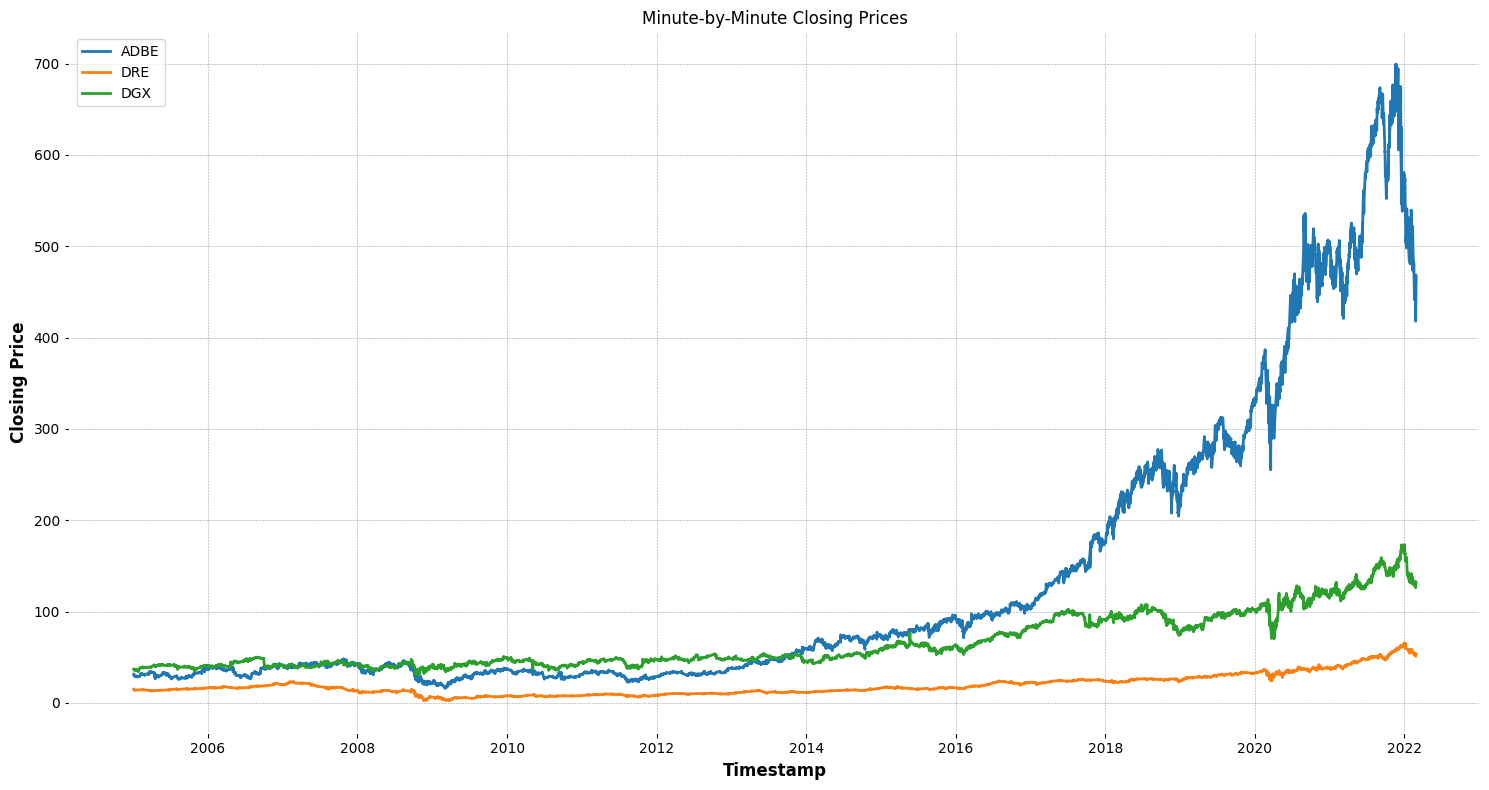

In [193]:
stocks = {
    'ADBE' : ADBE_1MIN,
    'DRE': DRE_1MIN,
    'DGX': DGX_1MIN
}
plot_mbym(stocks)


Moving averages make more sense here

In [194]:
def plot_moving_averages(stock_data_dict, window=10000):
   
    plt.figure(figsize=(15, 7))
    
    for stock_name, df in stock_data_dict.items():
     
        moving_avg = df["Close"].rolling(window=window).mean() ### taking moving averages
        plt.plot(df['Timestamp'], moving_avg, label=f"{stock_name} {window}-min MA")
    
    plt.title(f'Minute-by-Minute {window}-Period Moving Averages')
    plt.xlabel('Timestamp')
    plt.ylabel('Moving Average')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

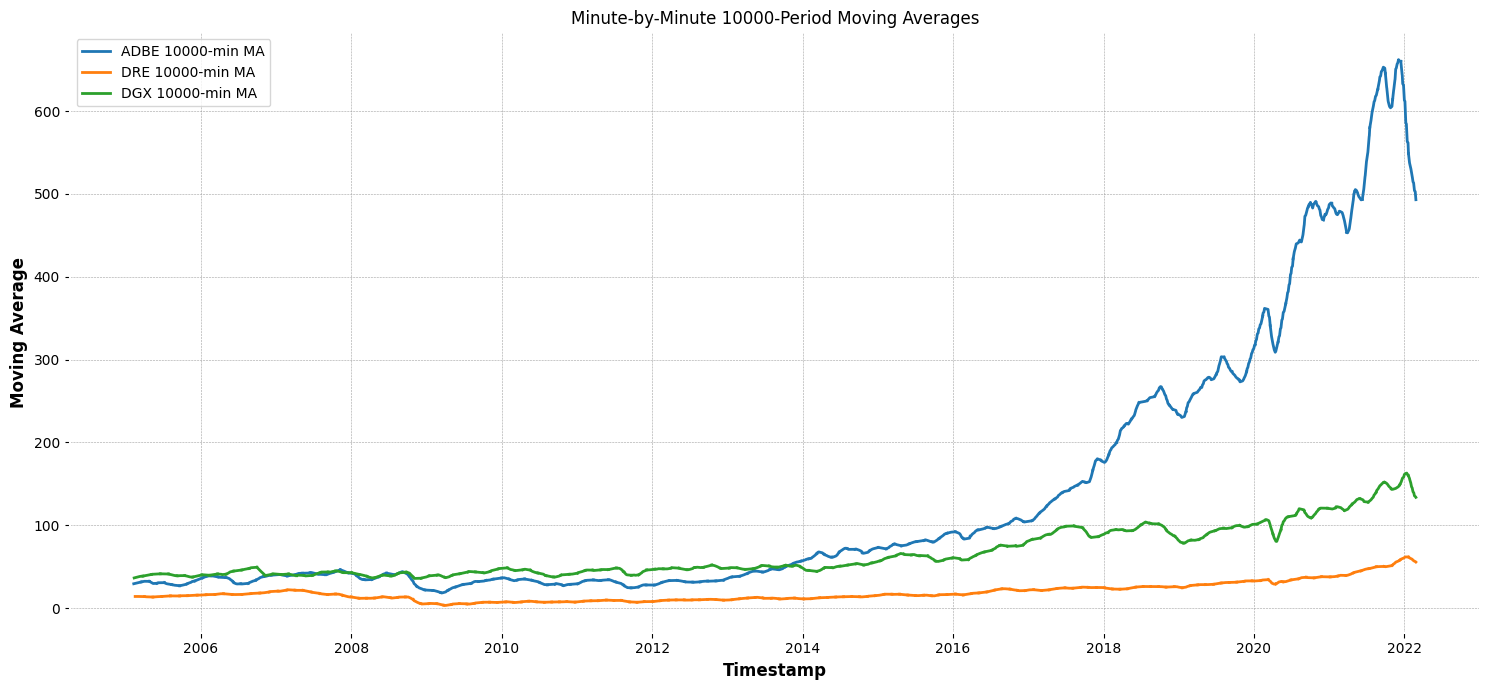

In [195]:
plot_moving_averages(stocks)

**b) Plot the day-by-day closing price series of a few stocks**

In [196]:
import matplotlib.pyplot as plt

def plot_dailyCP(stocks):
    plt.figure(figsize=(15, 7))
    
    for stock, df in stocks.items():
        daily_closing_prices = df.resample('D', on='Timestamp').last()
        daily_closing_prices.dropna(subset=['Close'], inplace=True)
        plt.plot(daily_closing_prices.index, daily_closing_prices['Close'], label=stock)
    
    plt.title('Day-by-Day Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


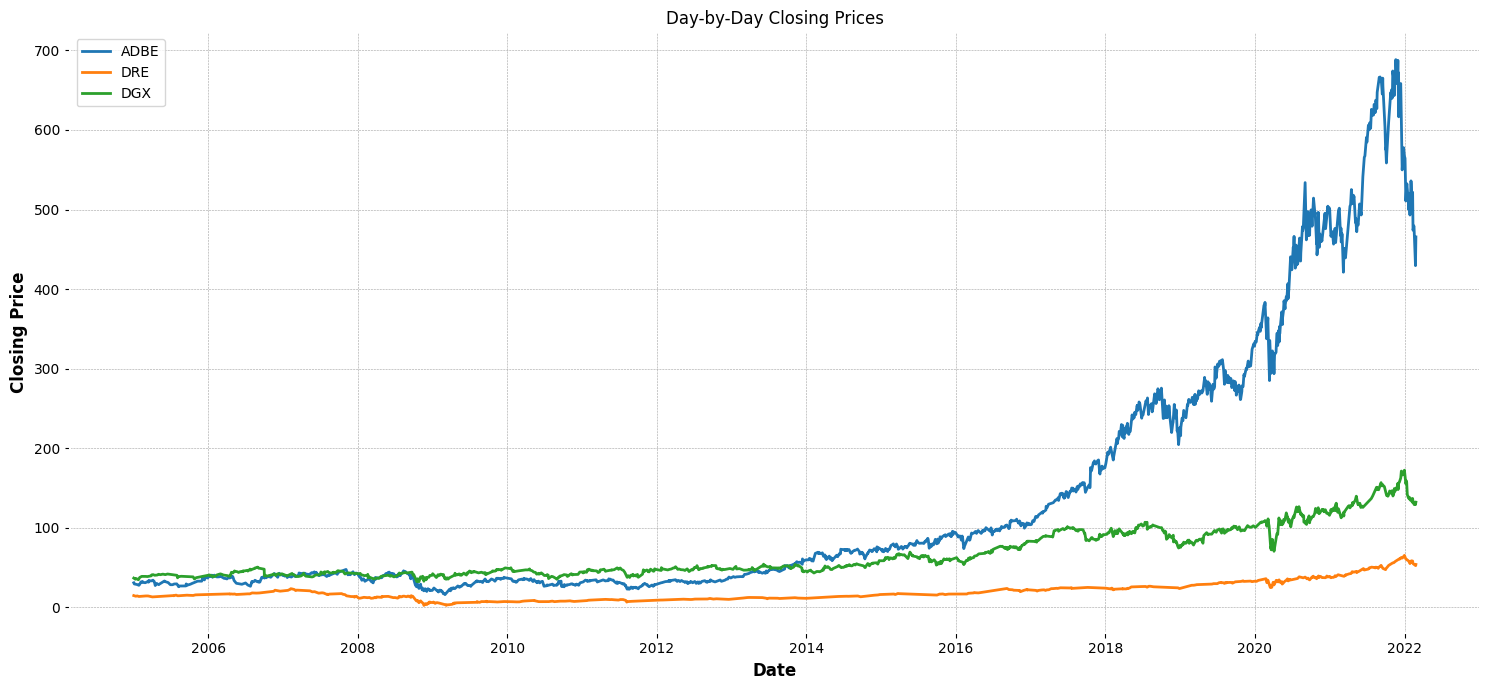

In [197]:
plot_dailyCP(stocks)


**c) Plot a complete candlestick chart with volume on secondary y-axis for a few stocks with a
time period of your choice**

In [198]:
def candlestick(df, title, days=30):
                                        
    dfnew = df.set_index('Timestamp') # Set 'Timestamp' as the index
    df_to_plot = dfnew[-days:] # Filter the data for the desired number of days
    mpf.plot(df_to_plot, type='candle', style='charles', 
             title=title, volume=True, ylabel='Price', ylabel_lower='Volume', 
             tight_layout=True) # Create a candlestick plot with volume


In [199]:
def candlestick(df, title, days=30):
    df_new = df.set_index('Timestamp') # Set 'Timestamp' as the index
    daily_data = df_new.resample('D').agg({'Open': 'first',  # Resample data to daily frequency,
                                       'High': 'max', ##taking out important metrics
                                       'Low': 'min', 
                                       'Close': 'last',
                                       'Volume': 'sum'}).dropna()
    
   
    df_to_plot = daily_data[-days:] # selecting last "days" days
    mpf.plot(df_to_plot, type='candle', style='charles',   # Create a candlestick plot with volume
             title=title, volume=True, ylabel='Price', ylabel_lower='Volume', 
             tight_layout=True)


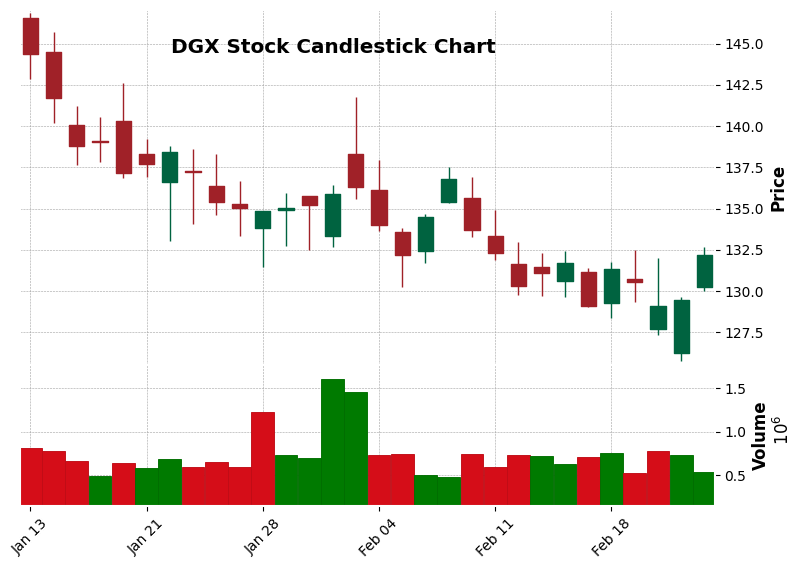

In [200]:
candlestick(DGX_1MIN, title="DGX Stock Candlestick Chart", days=30)

**DATA_LOADERS**

SPLIT DATASET INTO TRAIN , TEST AND VALIDATION SET

In [201]:
# #### So I am taking last 2 years for testing , 2 years for validation and rest of data for training
# def split_data(dataframe, start_date, validation_duration_years=1, test_duration_years=2):
#     dataframe = dataframe[dataframe['Timestamp'] >= start_date] # Filter data to only include rows from start_date onward
    
#     test_cutoff_date = dataframe['Timestamp'].max() - pd.DateOffset(years=test_duration_years) # Determine the cutoff dates for the training and validation data
#     validation_cutoff_date = test_cutoff_date - pd.DateOffset(years=validation_duration_years)

#     train_data = dataframe[dataframe['Timestamp'] <= validation_cutoff_date] # Split the data into training, validation, and testing based on the cutoff dates
#     validation_data = dataframe[(dataframe['Timestamp'] > validation_cutoff_date) & (dataframe['Timestamp'] <= test_cutoff_date)]
#     test_data = dataframe[dataframe['Timestamp'] > test_cutoff_date]
    
#     return train_data, validation_data, test_data

In [202]:
def split_data(dataframe, start_date, validation_duration_months=12, test_duration_months=24):
    dataframe = dataframe[dataframe['Timestamp'] >= start_date] # Filter data to only include rows from start_date onward
    
    test_cutoff_date = dataframe['Timestamp'].max() - pd.DateOffset(months=test_duration_months) # Determine the cutoff dates for the training and validation data
    validation_cutoff_date = test_cutoff_date - pd.DateOffset(months=validation_duration_months)

    train_data = dataframe[dataframe['Timestamp'] <= validation_cutoff_date] # Split the data into training, validation, and testing based on the cutoff dates
    validation_data = dataframe[(dataframe['Timestamp'] > validation_cutoff_date) & (dataframe['Timestamp'] <= test_cutoff_date)]
    test_data = dataframe[dataframe['Timestamp'] > test_cutoff_date]
    
    return train_data, validation_data, test_data


In [203]:
DREtrain_data, DREvalidation_data, DREtest_data = split_data(DGX_1MIN,start_date="2012-01-12")

In [204]:
print(DREtrain_data[:5])
print(DREtrain_data.tail())

                 Timestamp     Open     High      Low    Close  Volume
674693 2012-01-12 09:30:00  47.1359  47.1359  47.0292  47.0867   10588
674694 2012-01-12 09:32:00  47.1195  47.1195  47.1031  47.1031     600
674695 2012-01-12 09:33:00  47.0867  47.1523  47.0867  47.1113    2600
674696 2012-01-12 09:35:00  47.0867  47.1441  47.0867  47.1031    2700
674697 2012-01-12 09:36:00  47.1441  47.1688  47.0046  47.0456    4300
                  Timestamp     Open     High      Low    Close  Volume
1335430 2019-02-25 15:55:00  82.0622  82.0622  81.9963  82.0340   10141
1335431 2019-02-25 15:56:00  82.0152  82.0434  82.0058  82.0434    6403
1335432 2019-02-25 15:57:00  82.0434  82.0857  82.0434  82.0622    9124
1335433 2019-02-25 15:58:00  82.0810  82.0904  82.0340  82.0434   11188
1335434 2019-02-25 15:59:00  82.0434  82.0622  82.0152  82.0246   20694


In [205]:
print(DREvalidation_data[:5])
print(DREvalidation_data.head())

                  Timestamp     Open     High      Low    Close  Volume
1335436 2019-02-26 09:30:00  81.9117  82.1657  81.8834  81.9822   10451
1335437 2019-02-26 09:31:00  81.8552  81.8552  81.4224  81.4412    7398
1335438 2019-02-26 09:32:00  81.4224  81.4459  81.4224  81.4318     300
1335439 2019-02-26 09:33:00  81.3848  81.4130  81.2437  81.2719    2842
1335440 2019-02-26 09:34:00  81.3001  81.6859  81.3001  81.6859    9934
                  Timestamp     Open     High      Low    Close  Volume
1335436 2019-02-26 09:30:00  81.9117  82.1657  81.8834  81.9822   10451
1335437 2019-02-26 09:31:00  81.8552  81.8552  81.4224  81.4412    7398
1335438 2019-02-26 09:32:00  81.4224  81.4459  81.4224  81.4318     300
1335439 2019-02-26 09:33:00  81.3848  81.4130  81.2437  81.2719    2842
1335440 2019-02-26 09:34:00  81.3001  81.6859  81.3001  81.6859    9934


In [206]:
print(DREtest_data[:5])
print(DREtest_data.tail())

                  Timestamp      Open      High       Low     Close  Volume
1426847 2020-02-26 09:30:00  106.7353  106.7353  106.5719  106.5767   12341
1426848 2020-02-26 09:31:00  106.6776  106.7833  106.5335  106.5335    1434
1426849 2020-02-26 09:33:00  106.4903  106.6344  106.4903  106.6200    1100
1426850 2020-02-26 09:34:00  106.6200  106.7737  106.6200  106.6680     800
1426851 2020-02-26 09:35:00  106.6296  106.8121  106.6296  106.7449    1800
                  Timestamp     Open    High      Low    Close  Volume
1619367 2022-02-25 15:55:00  132.080  132.22  132.035  132.185    9745
1619368 2022-02-25 15:56:00  132.175  132.22  132.070  132.190    8858
1619369 2022-02-25 15:57:00  132.180  132.18  132.060  132.120    9281
1619370 2022-02-25 15:58:00  132.130  132.18  132.080  132.170   10689
1619371 2022-02-25 15:59:00  132.175  132.19  132.110  132.170   16337


In [207]:
# So here I am Splitting DataFrame , one containing TimeStamp and other Relevant Numerical Data
def DividingDF(df):
    timestamp_df = df[['Timestamp']]
    stockTrainingDF = df.drop(columns=['Timestamp'])
    for col in stockTrainingDF.columns:
        stockTrainingDF[col] = stockTrainingDF[col].astype(float)
    
    return timestamp_df, stockTrainingDF

In [208]:
DREtrain_time,DREtrain_modelData = DividingDF(DREtrain_data)
print(DREtrain_time.head(),DREtrain_modelData.head())
DREvalid_time,DREvalid_modelData = DividingDF(DREvalidation_data)
print(DREvalid_time.head(),DREvalid_modelData.head())
DREtest_time,DREtest_modelData = DividingDF(DREtest_data)
print(DREtest_time.head(),DREtest_modelData.head())

                 Timestamp
674693 2012-01-12 09:30:00
674694 2012-01-12 09:32:00
674695 2012-01-12 09:33:00
674696 2012-01-12 09:35:00
674697 2012-01-12 09:36:00            Open     High      Low    Close   Volume
674693  47.1359  47.1359  47.0292  47.0867  10588.0
674694  47.1195  47.1195  47.1031  47.1031    600.0
674695  47.0867  47.1523  47.0867  47.1113   2600.0
674696  47.0867  47.1441  47.0867  47.1031   2700.0
674697  47.1441  47.1688  47.0046  47.0456   4300.0
                  Timestamp
1335436 2019-02-26 09:30:00
1335437 2019-02-26 09:31:00
1335438 2019-02-26 09:32:00
1335439 2019-02-26 09:33:00
1335440 2019-02-26 09:34:00             Open     High      Low    Close   Volume
1335436  81.9117  82.1657  81.8834  81.9822  10451.0
1335437  81.8552  81.8552  81.4224  81.4412   7398.0
1335438  81.4224  81.4459  81.4224  81.4318    300.0
1335439  81.3848  81.4130  81.2437  81.2719   2842.0
1335440  81.3001  81.6859  81.3001  81.6859   9934.0
                  Timestamp
1426847 2020

In [209]:
# def transform_data(train_data, valid_data, test_data):
#     ## so a we always standardise the sets using mean and standard deviation from transformed from Train Set 
#     scaler = StandardScaler() # Fit the scaler using only the training data
#     scaler.fit(train_data)
    
#     train_transformed = scaler.transform(train_data) # Transform all three datasets using #the fitted scaler
#     valid_transformed = scaler.transform(valid_data)
#     test_transformed = scaler.transform(test_data) 
    
#     train_df = pd.DataFrame(train_transformed, columns=train_data.columns) 
#     valid_df = pd.DataFrame(valid_transformed, columns=valid_data.columns)
#     test_df = pd.DataFrame(test_transformed, columns=test_data.columns)
    
#     return train_df, valid_df, test_df, scaler

In [210]:
def transform_data(train_data, valid_data, test_data):
    ## so a we always normalize the sets to a range (-1, 1) using the training data
    scaler = MinMaxScaler(feature_range=(-1, 1))  # Fit the scaler using only the training data
    scaler.fit(train_data)
    
    train_transformed = scaler.transform(train_data)  # Transform all three datasets using the fitted scaler
    valid_transformed = scaler.transform(valid_data)
    test_transformed = scaler.transform(test_data) 
    
    train_df = pd.DataFrame(train_transformed, columns=train_data.columns) 
    valid_df = pd.DataFrame(valid_transformed, columns=valid_data.columns)
    test_df = pd.DataFrame(test_transformed, columns=test_data.columns)
    
    return train_df, valid_df, test_df, scaler

In [211]:
DREtrain_scaled, DREvalid_scaled, DREtest_scaled, scaler = transform_data(DREtrain_modelData, DREvalid_modelData, DREtest_modelData)

In [212]:
DREtrain_scaled[:5]

,Open,High,Low,Close,Volume
0,-0.868551,-0.869545,-0.871182,-0.870233,-0.979737
1,-0.869059,-0.870050,-0.868893,-0.869726,-0.998870
2,-0.870074,-0.869041,-0.869401,-0.869472,-0.995039
3,-0.870074,-0.869293,-0.869401,-0.869726,-0.994847
4,-0.868297,-0.868533,-0.871943,-0.871505,-0.991782


In [213]:
DREvalid_scaled[:5]

,Open,High,Low,Close,Volume
0,0.208203,0.207935,0.208111,0.209986,-0.979999
1,0.206453,0.198385,0.193836,0.193239,-0.985847
2,0.193053,0.185795,0.193836,0.192948,-0.999444
3,0.191888,0.184783,0.188302,0.187998,-0.994575
4,0.189266,0.193177,0.190049,0.200814,-0.980989


In [214]:
DREtest_scaled[:5]

,Open,High,Low,Close,Volume
0,0.976809,0.963671,0.972614,0.971329,-0.976379
1,0.975022,0.965147,0.971425,0.969991,-0.997272
2,0.969223,0.960567,0.970087,0.972669,-0.997912
3,0.973239,0.964852,0.974103,0.974155,-0.998487
4,0.973536,0.966033,0.974400,0.976535,-0.996571


In [215]:
##Parameters:- prediction (np.array):- scaler (StandardScaler): The scaler object
##Returns:- original_pred (DataFrame):
    
# def upscale_predicted(prediction, scaler):
#     mean = scaler.mean_[3] ### taking out parameters from scaler
#     std = scaler.scale_[3]
#     original_values = [pred * std + mean for pred in prediction] ### inversing the affect of scalar
#     original_pred = pd.DataFrame(original_values)

#     return original_pred


In [216]:
def upscale_predicted(prediction, scaler):
    # Using the inverse_transform method of the MinMaxScaler for upscaling
    prediction = np.array(prediction).reshape(-1, 1)
    original_values = scaler.inverse_transform(np.hstack([np.zeros((prediction.shape[0], 3)), prediction, np.zeros((prediction.shape[0], 1))]))[:, 3]
    
    original_pred = pd.DataFrame(original_values)

    return original_pred

In [217]:
## here we are using sliding window technique
def generate_sequences(df, n_past=15, n_future=1):  ## take our dataframes as inputs
    
    df_for_training_scaled = df.values # Convert the DataFrame to numpy array(makes things easy)
    
    batchX = []
    batchY = []
    for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
        batchX.append(df_for_training_scaled[i - n_past:i, 0:df.shape[1]]) ### appends a n_past rows and all features (as column)
        batchY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 3]) ### appends a label at n_past+1 place for the prediction values

    batchX, batchY = np.array(batchX), np.array(batchY) ### converting list to numpy arrays
    
    return batchX, batchY #### numpy arrays 

In [218]:
trainX, trainY = generate_sequences(DREtrain_scaled, n_past=15, n_future=1)
trainX[0],trainY[0]

(array([[-0.86855085, -0.86954509, -0.87118171, -0.87023319, -0.97973662],
        [-0.86905864, -0.87004954, -0.86889332, -0.86972551, -0.99886979],
        [-0.87007422, -0.86904064, -0.86940117, -0.86947168, -0.99503856],
        [-0.87007422, -0.86929287, -0.86940117, -0.86972551, -0.994847  ],
        [-0.86829696, -0.86853312, -0.87194347, -0.87150547, -0.99178201],
        [-0.87134679, -0.87232262, -0.87168955, -0.87252083, -0.99657105],
        [-0.87236236, -0.8730793 , -0.87321617, -0.87379311, -0.99772042],
        [-0.87363493, -0.87333152, -0.87347009, -0.8730285 , -0.99637949],
        [-0.87287015, -0.87383597, -0.87321617, -0.87404695, -0.99886979],
        [-0.87465051, -0.87408819, -0.87473969, -0.87556997, -0.99542168],
        [-0.87500658, -0.87257485, -0.87473969, -0.87175931, -0.97171211],
        [-0.87172763, -0.86904064, -0.87118171, -0.86921784, -0.97511616],
        [-0.86855085, -0.86954509, -0.86940117, -0.86972551, -0.98373643],
        [-0.87032811, -0.

In [219]:
validX, validY = generate_sequences(DREvalid_scaled, n_past=15, n_future=1)
validX[0],validY[0]

(array([[ 0.20820264,  0.2079352 ,  0.20811122,  0.20998573, -0.97999906],
        [ 0.20645325,  0.19838454,  0.19383592,  0.19323863, -0.98584743],
        [ 0.19305258,  0.1857949 ,  0.19383592,  0.19294764, -0.99944447],
        [ 0.19188839,  0.18478293,  0.18830231,  0.18799781, -0.99457498],
        [ 0.18926584,  0.19317705,  0.19004879,  0.20081352, -0.98098943],
        [ 0.19858872,  0.19389988,  0.19922709,  0.19897784, -0.99906135],
        [ 0.20150231,  0.20822433,  0.20228652,  0.21595711, -0.98940473],
        [ 0.21577613,  0.20764606,  0.20956971,  0.21537514, -0.99498492],
        [ 0.21111624,  0.20301684,  0.20927863,  0.20809433, -0.99906135],
        [ 0.2061622 ,  0.19867367,  0.2054915 ,  0.20430843, -0.9958048 ],
        [ 0.20295756,  0.197228  ,  0.20374192,  0.20430843, -0.98640105],
        [ 0.20470695,  0.19780627,  0.204033  ,  0.20547237, -0.99449069],
        [ 0.2055801 ,  0.19983329,  0.20636474,  0.20663631, -0.99408075],
        [ 0.2079116 ,  0.

In [220]:
testX, testY = generate_sequences(DREtest_scaled, n_past=15, n_future=1)
testX[0],testY[0]

(array([[ 0.97680892,  0.96367059,  0.97261373,  0.97132872, -0.97637855],
        [ 0.97502237,  0.96514702,  0.97142463,  0.96999143, -0.99727216],
        [ 0.96922305,  0.96056701,  0.97008691,  0.9726691 , -0.99791198],
        [ 0.97323892,  0.96485173,  0.97410319,  0.97415498, -0.99848666],
        [ 0.97353616,  0.96603288,  0.97440046,  0.97653549, -0.99657105],
        [ 0.97770065,  0.97076361,  0.97856538,  0.98337672, -0.99848666],
        [ 0.98365168,  0.97342118,  0.98421976,  0.98605131, -0.99944447],
        [ 0.98692444,  0.97371954,  0.98362212,  0.9848626 , -0.99944447],
        [ 0.98692444,  0.97371954,  0.98719249,  0.98635158, -0.99803649],
        [ 0.98722168,  0.97401483,  0.98570612,  0.98575413, -0.99886979],
        [ 0.98930238,  0.97608183,  0.98748976,  0.98843181, -0.99791198],
        [ 0.98959962,  0.97637712,  0.98748976,  0.98783746, -0.99925291],
        [ 0.98781617,  0.98435599,  0.98868195,  0.9970561 , -0.99679709],
        [ 0.99346687,  0.

In [221]:
class TimeSeriesDataset(Dataset): ### input is our above sequenced dataset
    def __init__(self, data, labels): ## input type: ndarray 
       
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [222]:
def create_dataloader(data, labels, batch_size=64, shuffle=False, num_workers=0):
 
    dataset = TimeSeriesDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return dataloader

In [223]:
### finally making the dataloaders !!!!
train_loader = create_dataloader(trainX, trainY , shuffle=True)
valid_loader = create_dataloader(validX, validY)
test_loader = create_dataloader(testX, testY)

In [224]:
def view_dataloader_contents(dataloader, num_batches=1): 
    
    if len(dataloader) == 0:# Ensure the DataLoader is not empty
        print("The DataLoader is empty.")
        return
    for i, (data, labels) in enumerate(dataloader): # Loop over the DataLoader to fetch and print batches
        if i >= num_batches:
            break
        print(f"Batch {i+1} Data:")
        print(data[0])
        print(f"Batch {i+1} Labels:")
        print(labels[0])
        print("------")


In [225]:
view_dataloader_contents(train_loader)

Batch 1 Data:
tensor([[-0.8563, -0.8574, -0.8558, -0.8566, -0.9993],
        [-0.8561, -0.8572, -0.8557, -0.8565, -0.9954],
        [-0.8561, -0.8572, -0.8557, -0.8565, -0.9983],
        [-0.8561, -0.8569, -0.8567, -0.8575, -0.9668],
        [-0.8571, -0.8582, -0.8572, -0.8580, -0.9918],
        [-0.8576, -0.8582, -0.8569, -0.8574, -0.9975],
        [-0.8566, -0.8577, -0.8567, -0.8575, -0.9987],
        [-0.8570, -0.8581, -0.8564, -0.8573, -0.9994],
        [-0.8569, -0.8580, -0.8563, -0.8571, -0.9998],
        [-0.8569, -0.8579, -0.8569, -0.8575, -0.9836],
        [-0.8574, -0.8579, -0.8567, -0.8571, -0.9956],
        [-0.8569, -0.8579, -0.8572, -0.8580, -0.9975],
        [-0.8576, -0.8584, -0.8572, -0.8580, -0.9958],
        [-0.8576, -0.8587, -0.8571, -0.8578, -0.9989],
        [-0.8571, -0.8582, -0.8572, -0.8580, -0.9956]])
Batch 1 Labels:
tensor([-0.8578])
------


In [226]:
view_dataloader_contents(valid_loader)

Batch 1 Data:
tensor([[ 0.2082,  0.2079,  0.2081,  0.2100, -0.9800],
        [ 0.2065,  0.1984,  0.1938,  0.1932, -0.9858],
        [ 0.1931,  0.1858,  0.1938,  0.1929, -0.9994],
        [ 0.1919,  0.1848,  0.1883,  0.1880, -0.9946],
        [ 0.1893,  0.1932,  0.1900,  0.2008, -0.9810],
        [ 0.1986,  0.1939,  0.1992,  0.1990, -0.9991],
        [ 0.2015,  0.2082,  0.2023,  0.2160, -0.9894],
        [ 0.2158,  0.2076,  0.2096,  0.2154, -0.9950],
        [ 0.2111,  0.2030,  0.2093,  0.2081, -0.9991],
        [ 0.2062,  0.1987,  0.2055,  0.2043, -0.9958],
        [ 0.2030,  0.1972,  0.2037,  0.2043, -0.9864],
        [ 0.2047,  0.1978,  0.2040,  0.2055, -0.9945],
        [ 0.2056,  0.1998,  0.2064,  0.2066, -0.9941],
        [ 0.2079,  0.2016,  0.2072,  0.2072, -0.9983],
        [ 0.2062,  0.1984,  0.2052,  0.2061, -0.9944]])
Batch 1 Labels:
tensor([0.2045])
------


In [227]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, dropout=0.1):
       
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
       
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output
input_dim = trainX.shape[2]  # Number of features in the data
hidden_dim = 32 # Size of the LSTM's hidden states
output_dim = 1  # Size of the output

model0 = LSTMModel(input_dim, hidden_dim, output_dim)    
print(model0)    

LSTMModel(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [228]:
import torch
import torch.nn as nn

class StockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.2, use_layer_norm=True):
        super(StockPredictor, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_dim) if use_layer_norm else None
        self.fc = nn.Linear(hidden_dim, 1)  # Predicting the 'Close' value
        
    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm(x)
        
        # Apply LayerNorm
        if self.layer_norm is not None:
            out = self.layer_norm(out)
        
        # Only take the output from the final time step
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_dim = 5  # 5 features: 'Open', 'High', 'Low', 'Close', 'Volume'
hidden_dim = 64
num_layers = 2
dropout_rate = 0.3

model = StockPredictor(input_dim, hidden_dim, num_layers, dropout_rate)
print(model)


StockPredictor(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.3)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [229]:
import torch.nn.init as init

class Stock_Predictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.2, use_layer_norm=True):
        super(Stock_Predictor, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_dim) if use_layer_norm else None
        self.fc = nn.Linear(hidden_dim, 1)  # Predicting the 'Close' value
        
        # Apply Xavier initialization
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.xavier_uniform_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0)

    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm(x)
        
        # Apply LayerNorm
        if self.layer_norm is not None:
            out = self.layer_norm(out)
        
        # Only take the output from the final timestep
        out = self.fc(out[:, -1, :])
        return out
        
# Model parameters
input_dim = 5  # 5 features: 'Open', 'High', 'Low', 'Close', 'Volume'
hidden_dim = 32
num_layers = 2
dropout_rate = 0.2

# Create an instance of the model
model2 = Stock_Predictor(input_dim, hidden_dim, num_layers, dropout_rate)

# Print the model architecture
print(model2)

Stock_Predictor(
  (lstm): LSTM(5, 32, num_layers=2, batch_first=True, dropout=0.2)
  (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [230]:
import os

# Check if the directory exists. If not, create it.
if not os.path.exists('my_model'):
    os.makedirs('my_model')

In [231]:
# class EarlyStopping:
#     def __init__(self, patience=5, filename='best_model.pth'):
#         self.patience = patience
#         self.counter = 0
#         self.best_score = None
#         self.stop_training = False
#         # Modify the path to include the directory
#         self.filename = os.path.join('my_model', filename)

#     def check(self, val_loss, model):
#         score = -val_loss

#         if self.best_score is None:
#             self.best_score = score
#             self.save_model(val_loss, model)
#         elif score < self.best_score:
#             self.counter += 1
#             print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
#             if self.counter >= self.patience:
#                 self.stop_training = True
#         else:
#             self.best_score = score
#             self.save_model(val_loss, model)
#             self.counter = 0

#     def save_model(self, val_loss, model):
#         print(f"Validation loss decreased. Saving model...")
#         torch.save(model.state_dict(), self.filename)


In [232]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, train_loader, valid_loader, num_epochs=5):
    # Define the loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.000876)

    # Lists to store losses over the epochs
    train_losses = []
    valid_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        print(train_loss / len(train_loader))

        model.eval()  # Set the model to evaluation mode
        valid_loss = 0.0
        with torch.no_grad():
            for data, labels in valid_loader:
                outputs = model(data)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
        valid_losses.append(valid_loss / len(valid_loader))
        print(valid_loss / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} => "
              f"Train loss: {train_losses[-1]:.8f}, "
              f"Validation loss: {valid_losses[-1]:.8f}")

    # Plotting the losses
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(train_losses, label='Train Loss', alpha=0.5)
    plt.plot(valid_losses, label='Validation Loss', alpha=0.5)
    plt.title('Combined Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

0.0008785315685071794
1.3935332352324631e-05
Epoch 1/10 => Train loss: 0.00087853, Validation loss: 0.00001394
6.476321314078718e-06
6.703094962624399e-06
Epoch 2/10 => Train loss: 0.00000648, Validation loss: 0.00000670
4.8675474797221095e-06
8.08360527863032e-05
Epoch 3/10 => Train loss: 0.00000487, Validation loss: 0.00008084
4.225981483715946e-06
8.099098344896437e-06
Epoch 4/10 => Train loss: 0.00000423, Validation loss: 0.00000810
4.079869820263636e-06
1.674371922469415e-05
Epoch 5/10 => Train loss: 0.00000408, Validation loss: 0.00001674
3.921715109777661e-06
4.763204704408179e-06
Epoch 6/10 => Train loss: 0.00000392, Validation loss: 0.00000476
3.872197227260765e-06
5.606731534507937e-06
Epoch 7/10 => Train loss: 0.00000387, Validation loss: 0.00000561
3.7717558996258085e-06
4.386409461149578e-06
Epoch 8/10 => Train loss: 0.00000377, Validation loss: 0.00000439
3.7881844843316575e-06
8.266847897312756e-06
Epoch 9/10 => Train loss: 0.00000379, Validation loss: 0.00000827
3.72471

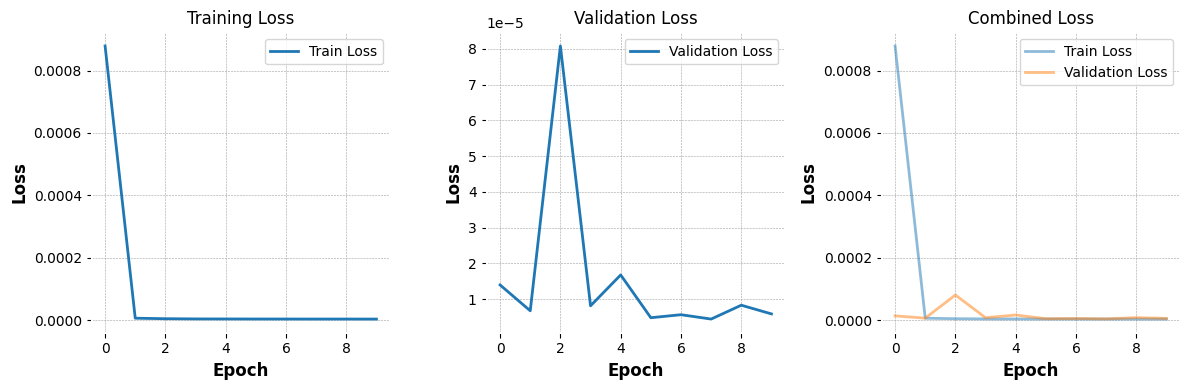

In [233]:
model0 = train_model(model0, train_loader, valid_loader, num_epochs=10)

In [234]:
def validate_and_plot(model, valid_loader):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    valid_predictions = []  ## storing the values in th elist , so to use it
    valid_true_values = [] ### in constructing the plot

    model.eval() # Model evaluation mode
    
    with torch.no_grad():
        for batch in valid_loader:
            data, labels = batch
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            
            
            valid_predictions.extend(outputs.detach().cpu().numpy()) # Append predictions and ground truth values
            valid_true_values.extend(labels.cpu().numpy())

    # Plotting Predictions vs. Ground Truth
    plt.figure(figsize=(12, 5))
    plt.plot(valid_true_values, label="Ground Truth", color="blue")
    plt.plot(valid_predictions, label="Predictions", color="red", linestyle="--")
    plt.title("Ground Truth vs. Predictions on Validation Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    return valid_predictions, valid_true_values

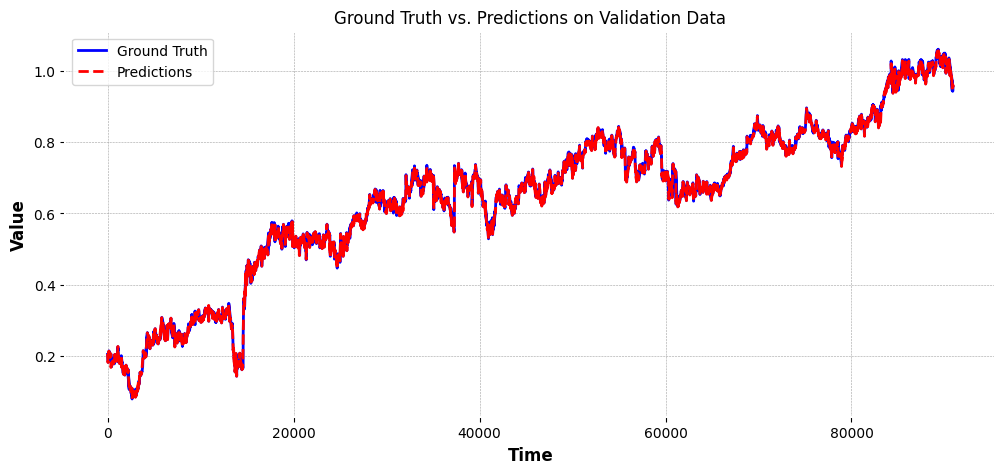

In [235]:
valid_predictions, valid_true_values = validate_and_plot(model0, valid_loader)

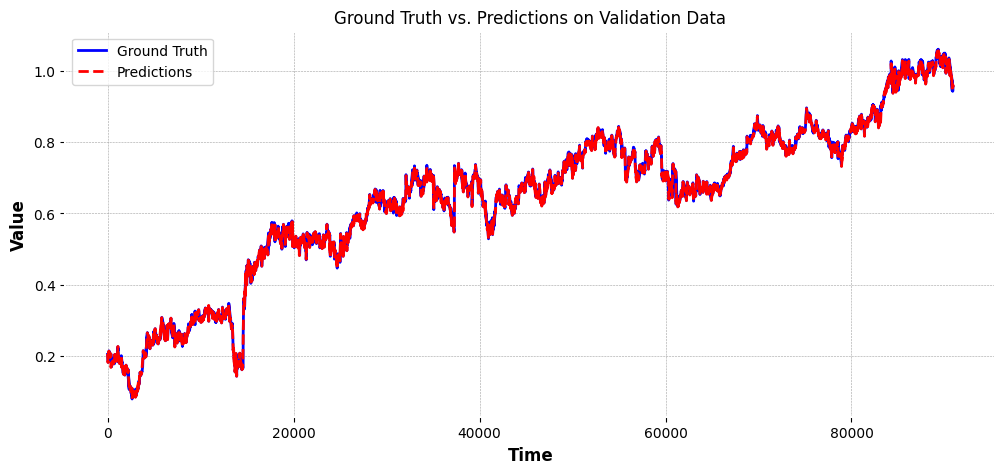

In [236]:
valid_predictions, valid_true_values = validate_and_plot(model0, valid_loader)

In [237]:
def plot_validation_predictions(predictions, true_values, timestamp, scaler):
    """
    Plot the validation predictions against the ground truth values.
    
    Parameters:
    - predictions (np.array): The model's predicted values (scaled).
    - true_values (np.array): Ground truth values (scaled).
    - timestamp (DataFrame): Timestamps corresponding to the validation data.
    - scaler (StandardScaler): The scaler object used to scale the original values.
    
    Returns:
    - None: Displays the plot.
    """
    predicted_unscaled = upscale_predicted(predictions, scaler)  # Unscale the predictions and true values using 
    true_unscaled = upscale_predicted(true_values, scaler) #the custom made descaler above
    
    # Trim the timestamp, predicted_unscaled, and true_unscaled to match the shortest length among them
    min_len = min(len(predicted_unscaled), len(timestamp), len(true_unscaled))
    timestamp_trimmed = timestamp.iloc[:min_len]
    predicted_unscaled = predicted_unscaled.iloc[:min_len]
    true_unscaled = true_unscaled.iloc[:min_len]
    
    plt.figure(figsize=(15, 6))
    plt.plot(timestamp_trimmed, true_unscaled, label='Ground Truth', color='blue')
    plt.plot(timestamp_trimmed, predicted_unscaled, label='Predictions', color='red', linestyle='--')
    plt.title("Ground Truth vs. Predictions on Validation Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

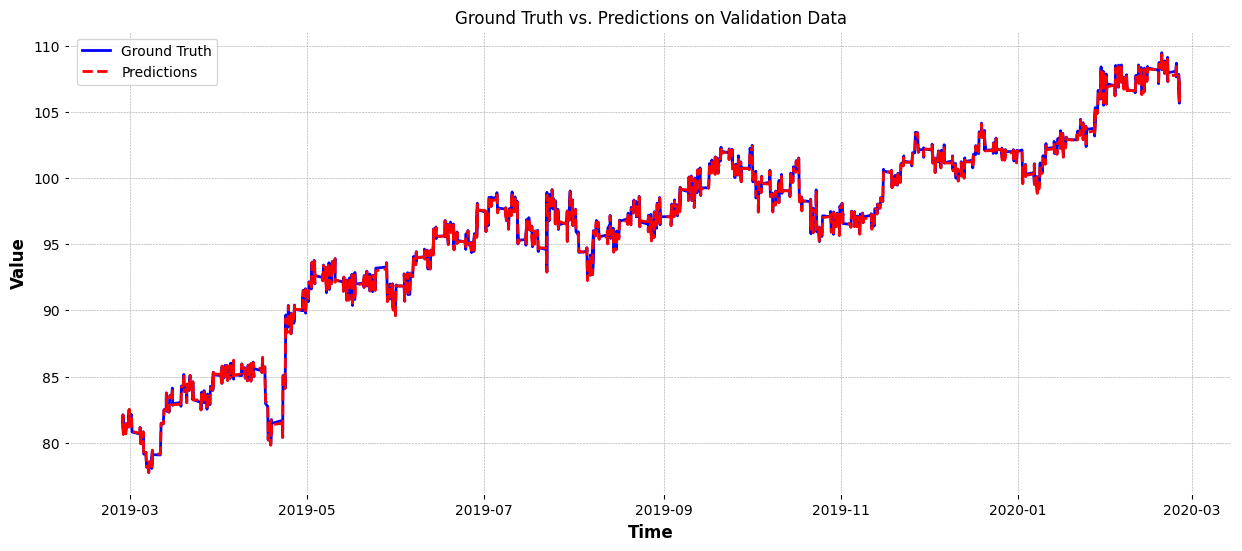

In [238]:
plot_validation_predictions(valid_predictions,valid_true_values, DREvalid_time, scaler)


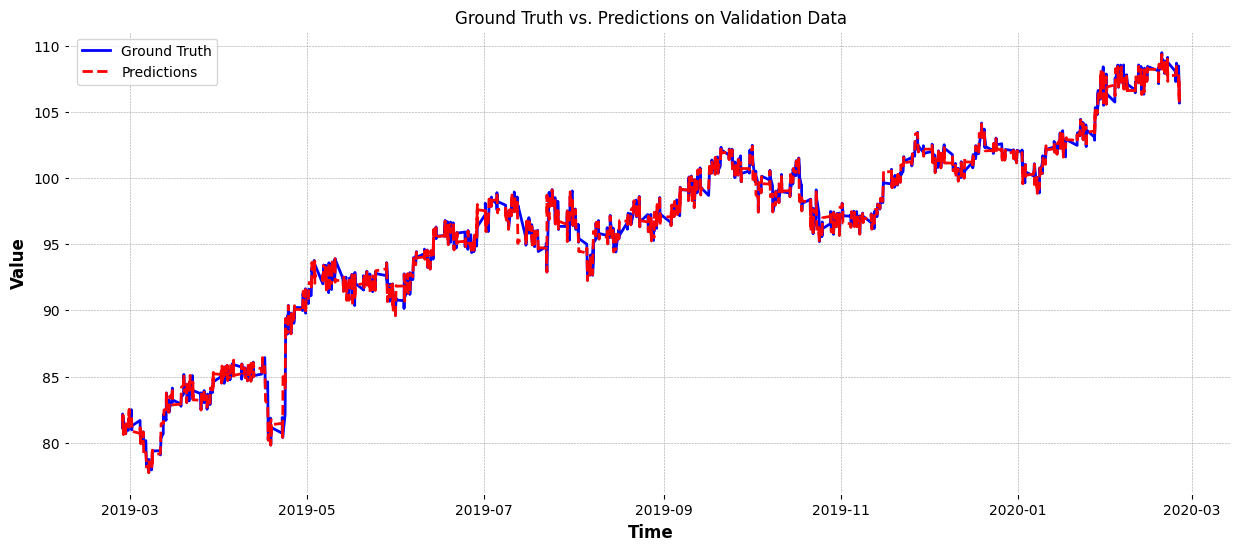

In [239]:
plot_validation_predictions(valid_predictions, DREvalid_scaled['Close'].values, DREvalid_time, scaler)


In [240]:
def test_and_plot(model, test_loader, criterion=nn.MSELoss()):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    
    test_predictions = [] # storing the predictions and ground truth values
    test_true_values = []
    total_test_loss = 0.0

    model.eval()
    
    with torch.no_grad():
        for batch in test_loader:
            data, labels = batch ## general steps , exaplained many times
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            
            if criterion: # If a criterion is provided, compute the test loss , if only want to plot
                loss = criterion(outputs, labels) ## use criterion = False
                total_test_loss += loss.item()
            
            test_predictions.extend(outputs.detach().cpu().numpy()) # Append predictions and ground truth values
            test_true_values.extend(labels.cpu().numpy())

    if criterion:
        print(f"Average Test Loss: {total_test_loss / len(test_loader):.4f}")

   
    plt.figure(figsize=(12, 5))  # Plotting Predictions vs. Ground Truth for Test Data
    plt.plot(test_true_values, label="Ground Truth", color="blue")
    plt.plot(test_predictions, label="Predictions", color="red", linestyle="--")
    plt.title("Ground Truth vs. Predictions on Test Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    return test_predictions, test_true_values


Average Test Loss: 0.0662


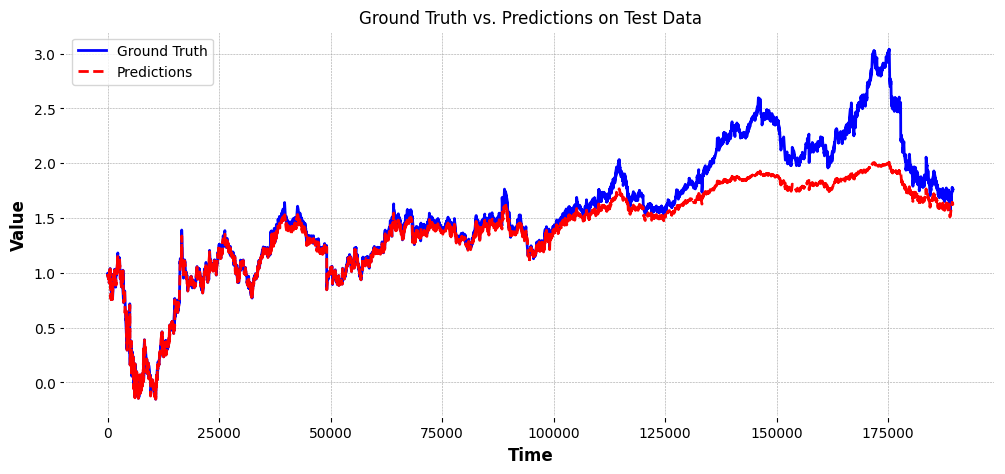

In [241]:

test_predictions, test_true_values = test_and_plot(model0, test_loader)

In [242]:
def plot_test_predictions(predictions, true_values, timestamp, scaler):
    """
    Plot the test predictions against the ground truth values.
    
    Parameters:
    - predictions (np.array): The model's predicted values (scaled).
    - true_values (np.array): Ground truth values (scaled).
    - timestamp (DataFrame): Timestamps corresponding to the test data.
    - scaler (MinMaxScaler): The scaler object used to scale the original values.
    
    Returns:
    - None: Displays the plot.
    """
    predicted_unscaled = upscale_predicted(predictions, scaler)  # Unscale the predictions using the custom function
    true_unscaled = upscale_predicted(true_values, scaler)
    
    # Trim the timestamp, predicted_unscaled, and true_unscaled to match the shortest length among them
    min_len = min(len(predicted_unscaled), len(timestamp), len(true_unscaled))
    timestamp_trimmed = timestamp.iloc[:min_len]
    predicted_unscaled = predicted_unscaled.iloc[:min_len]
    true_unscaled = true_unscaled.iloc[:min_len]
    
    plt.figure(figsize=(15, 6))
    plt.plot(timestamp_trimmed, true_unscaled, label='Ground Truth', color='blue')
    plt.plot(timestamp_trimmed, predicted_unscaled, label='Predictions', color='red', linestyle='--')
    plt.title("Ground Truth vs. Predictions on Test Data")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


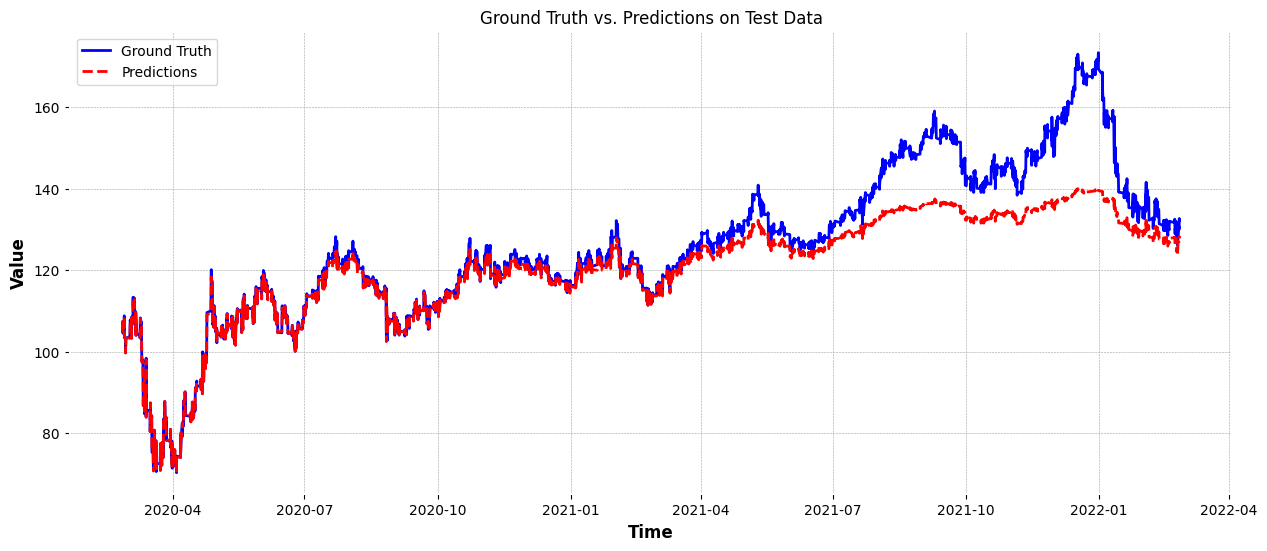

In [243]:
plot_test_predictions(test_predictions, test_true_values, DREtest_time, scaler)

In [244]:
def enhanced_trading_strategy(df):
    """
    An enhanced trading strategy based on MACD, RSI, Bollinger Bands, and Volume.

    Parameters:
    df (pd.DataFrame): DataFrame containing the stock data with 'Close' and 'Volume' columns.

    Returns:
    pd.Series: A series of decisions: 'Buy', 'Sell', or 'Hold'.
    """
    
    # MACD and Signal line indicators
    short_ema = df['Close'].ewm(span=12, adjust=False).mean() 
    long_ema = df['Close'].ewm(span=26, adjust=False).mean() 
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()
    
    # RSI
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    bollinger_upper = rolling_mean + (rolling_std*2)
    bollinger_lower = rolling_mean - (rolling_std*2)
    
    # Average volume
    avg_volume = df['Volume'].rolling(window=10).mean()

    decisions = []

    for i in range(len(df)):
        if i < 20:  # Skip the initial days for which we don't have enough data
            decisions.append('Hold')
            continue

        # Buy conditions
        if (macd.iloc[i] > signal.iloc[i] and
            rsi.iloc[i] < 30 and  # Oversold
            df['Close'].iloc[i] < bollinger_lower.iloc[i] and
            df['Volume'].iloc[i] > avg_volume.iloc[i]):
            decisions.append('Buy')
        # Sell conditions
        elif (macd.iloc[i] < signal.iloc[i] and
              rsi.iloc[i] > 70 and  # Overbought
              df['Close'].iloc[i] > bollinger_upper.iloc[i] and
              df['Volume'].iloc[i] > avg_volume.iloc[i]):
            decisions.append('Sell')
        # Hold conditions
        else:
            decisions.append('Hold')

    return pd.Series(decisions, index=df.index)

# Example usage:
DGX_1HR['Decision'] = enhanced_trading_strategy(DGX_1HR)


In [245]:
DGX_1HR.head()

,Timestamp,Open,High,Low,Close,Volume,Decision
0,2005-01-03 09:00:00,37.1719,37.2884,37.1408,37.1757,90000,Hold
1,2005-01-03 10:00:00,37.1874,37.2729,36.9271,36.9737,129000,Hold
2,2005-01-03 11:00:00,36.9776,36.9776,36.8844,36.9038,80000,Hold
3,2005-01-03 12:00:00,36.9232,36.9741,36.8650,36.9699,43200,Hold
4,2005-01-03 13:00:00,36.9737,37.0476,36.8339,36.8417,101000,Hold


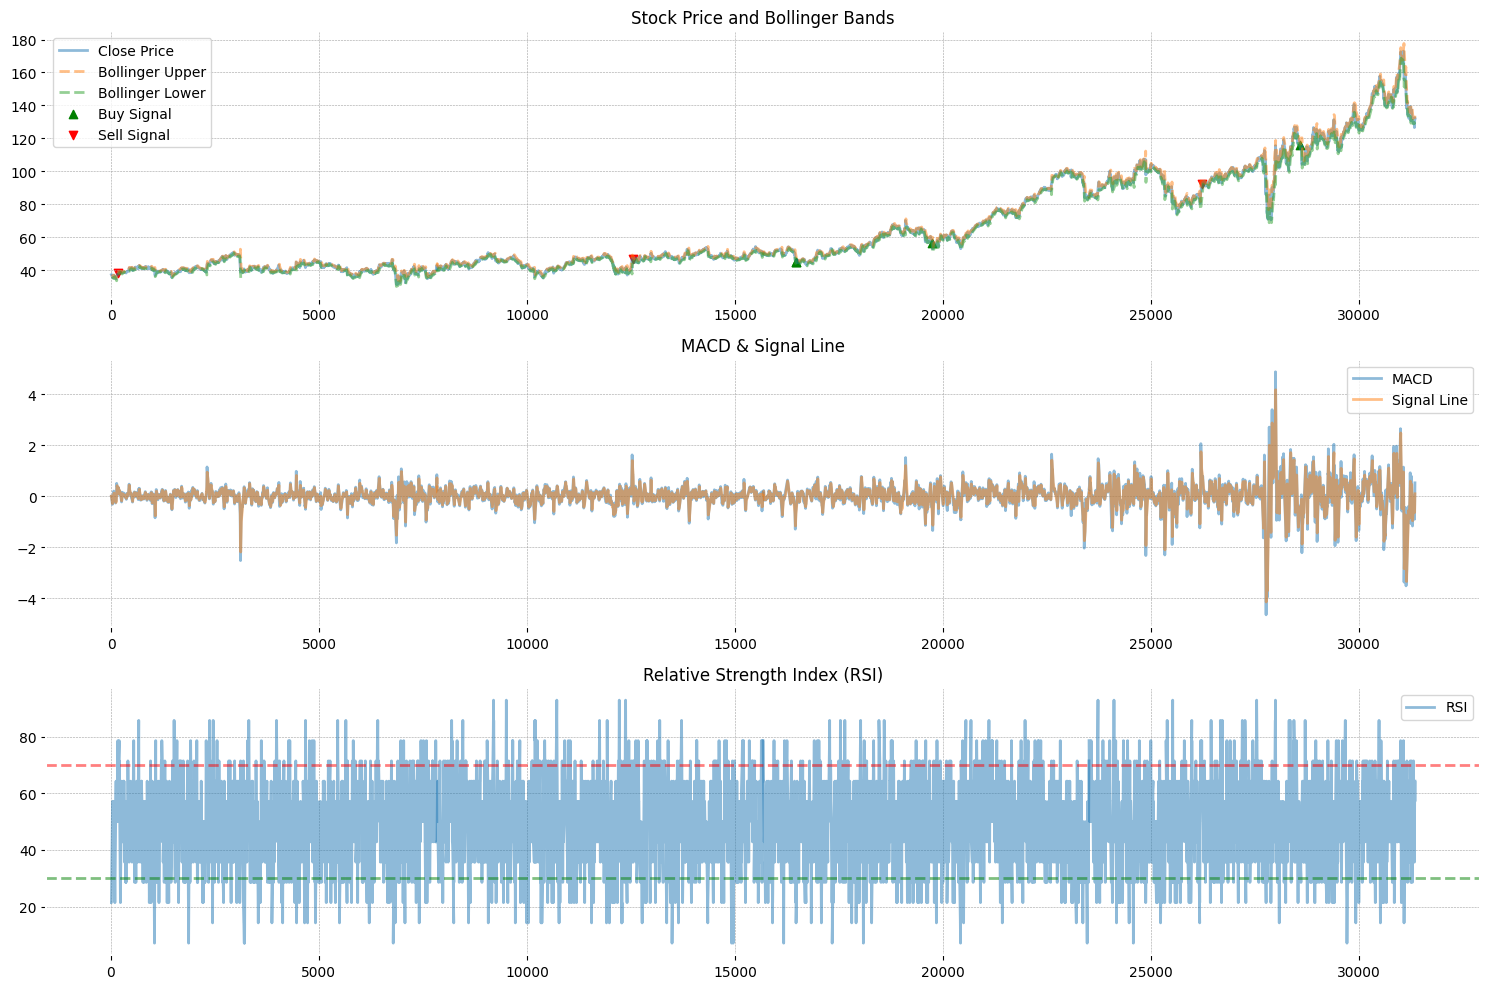

In [246]:
import matplotlib.pyplot as plt

def plot_strategy(df):
    decisions = enhanced_trading_strategy(df)
    buy_signals = df[decisions == 'Buy']
    sell_signals = df[decisions == 'Sell']
    
    # Calculate indicators
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()
    
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    bollinger_upper = rolling_mean + (rolling_std*2)
    bollinger_lower = rolling_mean - (rolling_std*2)
    
    # Plotting
    plt.figure(figsize=(15,10))
    
    # Closing Prices and Bollinger Bands
    plt.subplot(3, 1, 1)
    df['Close'].plot(label='Close Price', alpha=0.5)
    bollinger_upper.plot(label='Bollinger Upper', linestyle='--', alpha=0.5)
    bollinger_lower.plot(label='Bollinger Lower', linestyle='--', alpha=0.5)
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal', alpha=1)
    plt.title('Stock Price and Bollinger Bands')
    plt.legend(loc='best')
    
    # MACD and Signal Line
    plt.subplot(3, 1, 2)
    macd.plot(label='MACD', alpha=0.5)
    signal.plot(label='Signal Line', alpha=0.5)
    plt.title('MACD & Signal Line')
    plt.legend(loc='best')
    
    # RSI
    plt.subplot(3, 1, 3)
    df['Close'].diff().apply(lambda x: 100 if x > 0 else 0).rolling(window=14).mean().plot(label='RSI', alpha=0.5)
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    plt.title('Relative Strength Index (RSI)')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_strategy(DGX_1HR)


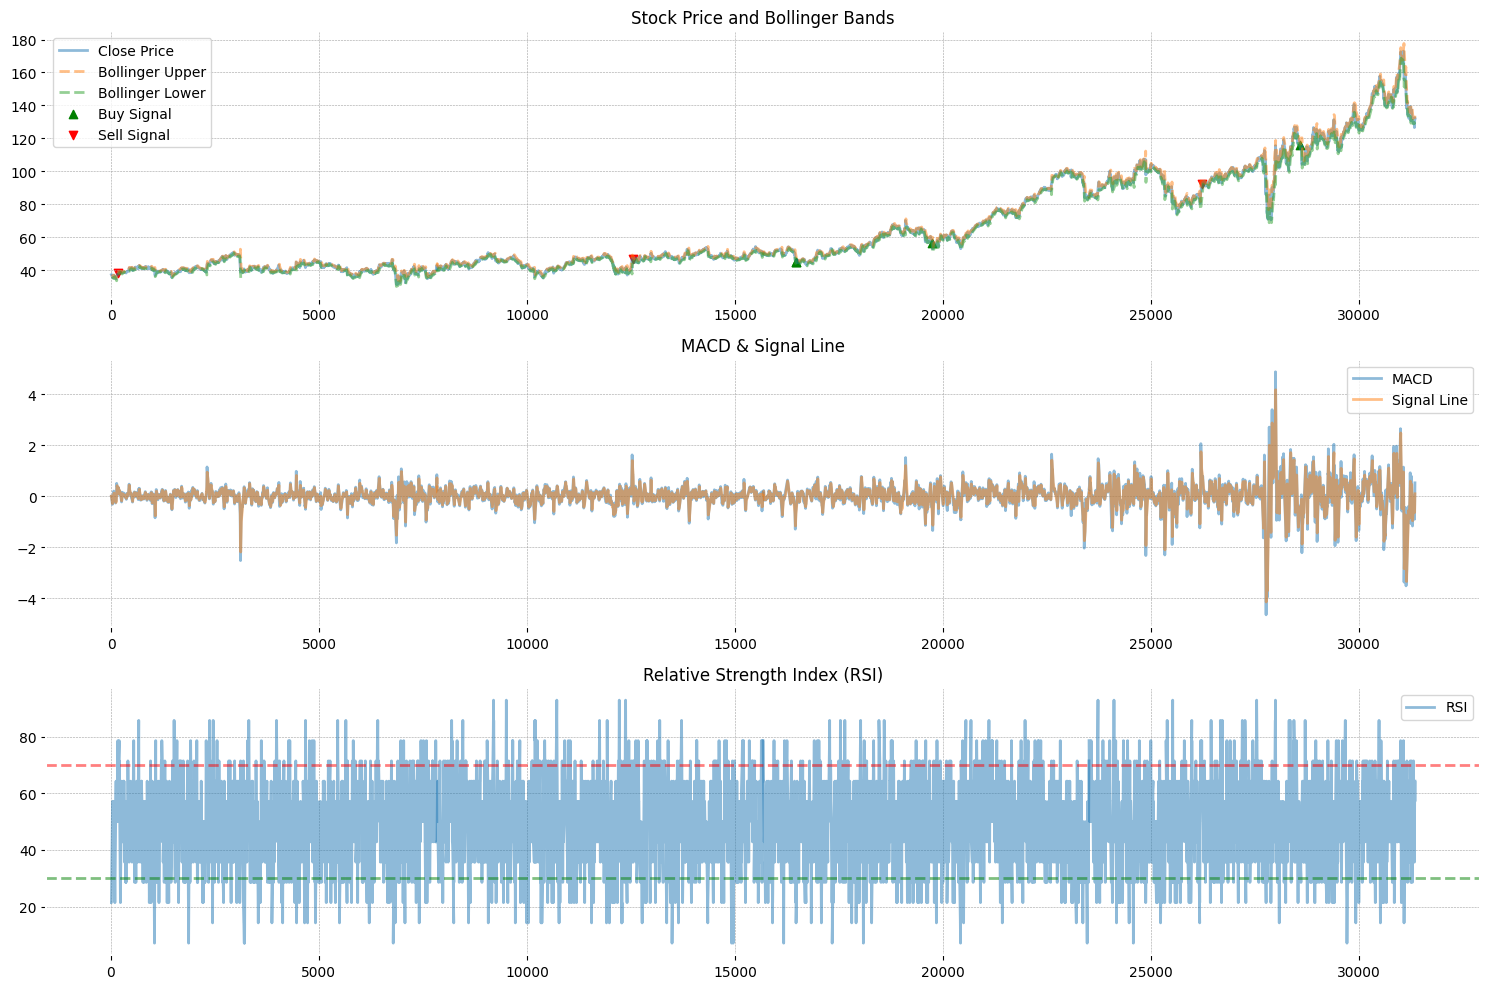

In [247]:
plot_strategy(DGX_1HR)

In [248]:
def all_data(data,generate_sequences,model,num_epochs=10):
    merged_train_data, merged_validation_data, merged_test_data = split_data(data,start_date="2012-01-12")
    merged_train_time , merged_train = DividingDF(merged_train_data)
    merged_valid_time , merged_valid = DividingDF(merged_validation_data)
    merged_test_time , merged_test = DividingDF(merged_test_data)
    merged_train_scaled, merged_valid_scaled, merged_test_scaled, scaler = transform_data(merged_train, merged_valid, merged_test)
    trainX , trainY = generate_sequences(merged_train_scaled)
    validX , validY = generate_sequences(merged_valid_scaled)
    testX , testY = generate_sequences(merged_test_scaled)
    train_loader = create_dataloader(trainX, trainY , shuffle=True)
    valid_loader = create_dataloader(validX, validY)
    test_loader = create_dataloader(testX, testY)
    model = train_model(model, train_loader, valid_loader, num_epochs)
    valid_predictions, valid_true_values = validate_and_plot(model, valid_loader)
    test_predictions, test_true_values = test_and_plot(model, test_loader)
    
    return merged_train_time, merged_valid_time , merged_test_time ,valid_predictions,test_predictions,valid_true_values,test_true_values
    

In [249]:
from functools import reduce

def read_multiple_stock_files(filenames):
    dfs = []
    for filename in filenames:
        df = cleaned_stock_data(filename)
        dfs.append(df[['Timestamp', 'Close']])
    
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='Timestamp'), dfs)
    merged_df.columns = ['Timestamp'] + [f'Close_{i}' for i in range(1, len(dfs)+1)]
    
    return merged_df

# Example usage:
filenames = ['AML782-22m2152/sp500_tickers_A-D_1min_1pppix/DRE_1min.txt', 'AML782-22m2152/sp500_tickers_A-D_1min_1pppix/DGX_1min.txt' , ]  # Add paths to your stock files here
merged_data = read_multiple_stock_files(filenames)

In [250]:
def generate_sequences2(df, n_past=15, n_future=1):  
    df_for_training_scaled = df.values 

    batchX = []
    batchY = []
    for i in range(n_past, len(df_for_training_scaled) - n_future +1):
        batchX.append(df_for_training_scaled[i - n_past:i, 0:])  # Using all but the first column as features
        batchY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])  # Using the first column as the target

    batchX, batchY = np.array(batchX), np.array(batchY) 
    
    return batchX, batchY

In [251]:
Cmodel = LSTMModel(input_dim=2 , hidden_dim= 32 , output_dim=1)    
print(Cmodel)   

LSTMModel(
  (lstm): LSTM(2, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


0.0011125037310929725
0.009995150597940755
Epoch 1/10 => Train loss: 0.00111250, Validation loss: 0.00999515
6.9552066157761285e-06
0.0019838101669760366
Epoch 2/10 => Train loss: 0.00000696, Validation loss: 0.00198381
4.458183175284056e-06
0.0004988454514570984
Epoch 3/10 => Train loss: 0.00000446, Validation loss: 0.00049885
3.3420888477114734e-06
0.00024762692987494986
Epoch 4/10 => Train loss: 0.00000334, Validation loss: 0.00024763
2.7533454106883127e-06
0.0002561806417552969
Epoch 5/10 => Train loss: 0.00000275, Validation loss: 0.00025618
2.57487890172416e-06
0.00026126660773782314
Epoch 6/10 => Train loss: 0.00000257, Validation loss: 0.00026127
2.442240318069784e-06
0.00022175064658408269
Epoch 7/10 => Train loss: 0.00000244, Validation loss: 0.00022175
2.37806954224596e-06
0.00032634369158391816
Epoch 8/10 => Train loss: 0.00000238, Validation loss: 0.00032634
2.329967551656614e-06
0.0003318810713702322
Epoch 9/10 => Train loss: 0.00000233, Validation loss: 0.00033188
2.2972

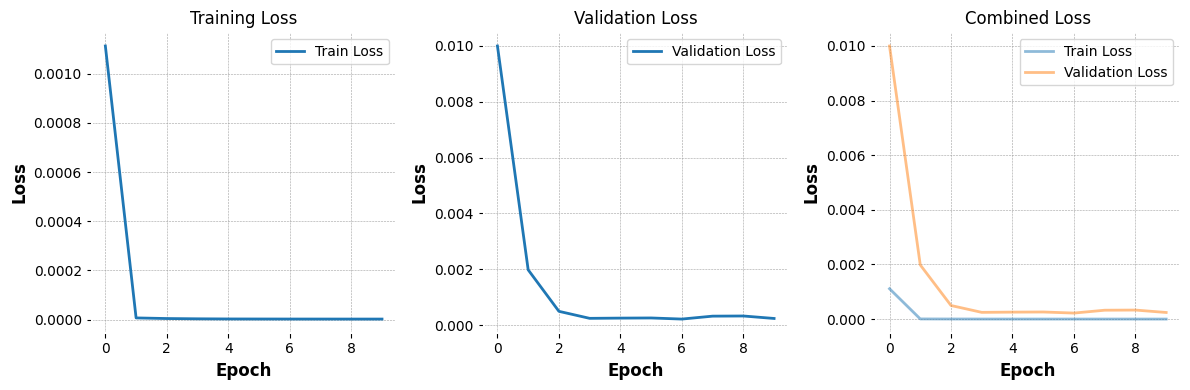

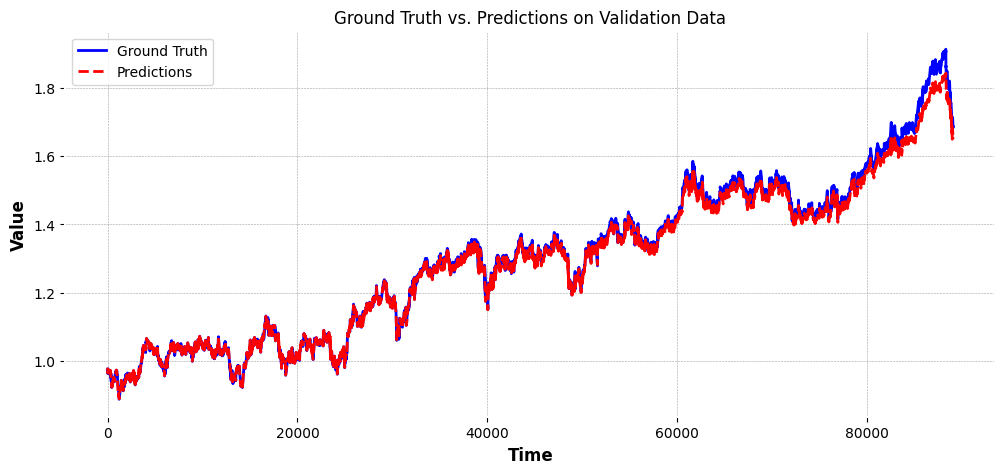

Average Test Loss: 0.3000


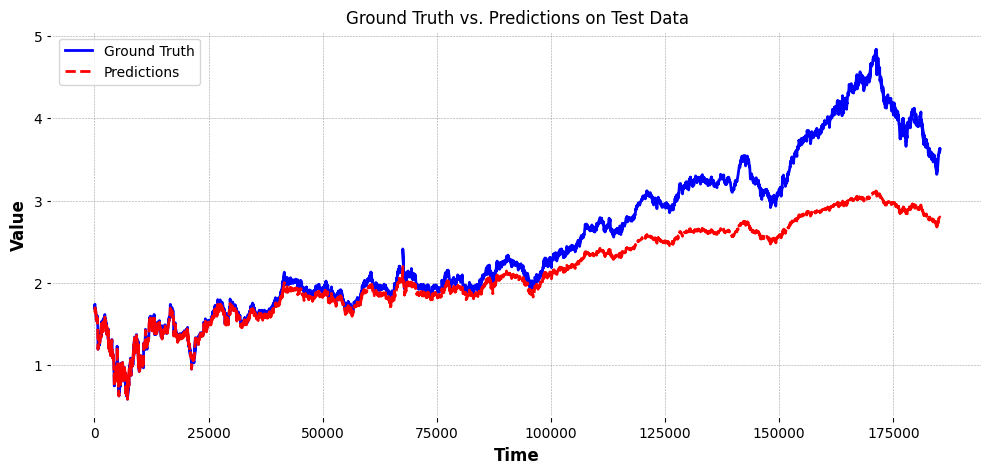

In [252]:
merged_train_time, merged_valid_time , merged_test_time ,valid_predictions,test_predictions,valid_true_values,test_true_values = all_data(merged_data,generate_sequences2,Cmodel)

In [253]:
def finalStockData_updated(df):
    new_df = df.copy()
    
    new_df = new_df.fillna(method='backfill')
    new_df = new_df.drop_duplicates()
    new_df = new_df.sort_values(by='Timestamp')
    
    # Add dayOfWeek column (Monday=1, Sunday=7)
    new_df['dayOfWeek'] = new_df['Timestamp'].dt.dayofweek + 1
    
    # Add monthOfYear column
    new_df['monthOfYear'] = new_df['Timestamp'].dt.month
    
    return new_df


In [254]:
NDRE_1MIN = finalStockData_updated(XDRE_1MIN)
NDRE_1MIN.head()

,Timestamp,Open,High,Low,Close,Volume,dayOfWeek,monthOfYear
0,2005-01-03 09:30:00,37.1719,37.1719,37.1563,37.1719,12800,1,1
1,2005-01-03 09:31:00,37.1757,37.1757,37.1757,37.1757,3600,1,1
2,2005-01-03 09:32:00,37.1757,37.2146,37.1757,37.2146,3800,1,1
3,2005-01-03 09:33:00,37.1835,37.1874,37.1796,37.1796,3200,1,1
4,2005-01-03 09:34:00,37.1757,37.1796,37.1408,37.1641,10000,1,1


In [255]:
Nmodel = LSTMModel(input_dim = 7, hidden_dim =32, output_dim =1)   

0.0010025381602346158
1.1410237320049523e-05
Epoch 1/10 => Train loss: 0.00100254, Validation loss: 0.00001141
7.1250473167405834e-06
9.899258005682983e-06
Epoch 2/10 => Train loss: 0.00000713, Validation loss: 0.00000990
5.382679732946892e-06
7.781513357528614e-05
Epoch 3/10 => Train loss: 0.00000538, Validation loss: 0.00007782
4.581443517122388e-06
6.498719322003385e-06
Epoch 4/10 => Train loss: 0.00000458, Validation loss: 0.00000650
4.2488503253769765e-06
9.150874556784283e-06
Epoch 5/10 => Train loss: 0.00000425, Validation loss: 0.00000915
4.218162741667215e-06
8.853284856301697e-06
Epoch 6/10 => Train loss: 0.00000422, Validation loss: 0.00000885
4.047005261221327e-06
7.0899144699347216e-06
Epoch 7/10 => Train loss: 0.00000405, Validation loss: 0.00000709
3.999893918154856e-06
5.247140872682936e-06
Epoch 8/10 => Train loss: 0.00000400, Validation loss: 0.00000525
3.899721204566284e-06
4.424930189087827e-06
Epoch 9/10 => Train loss: 0.00000390, Validation loss: 0.00000442
3.8539

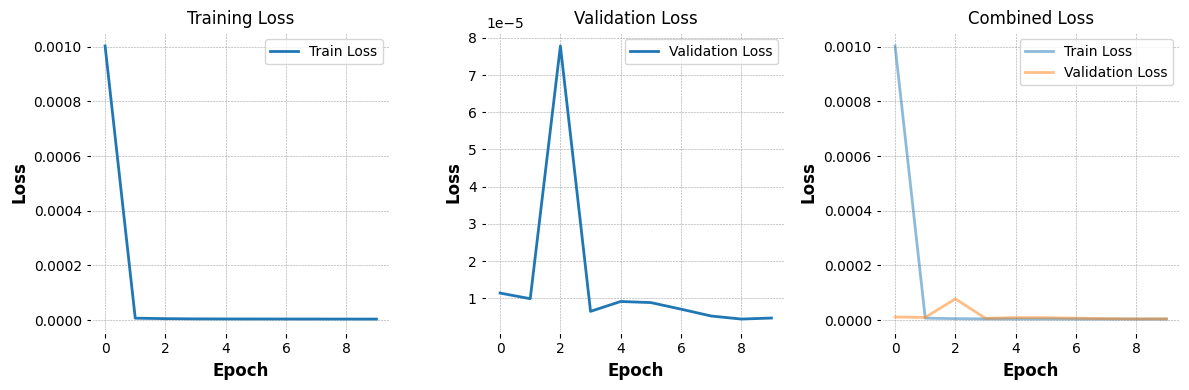

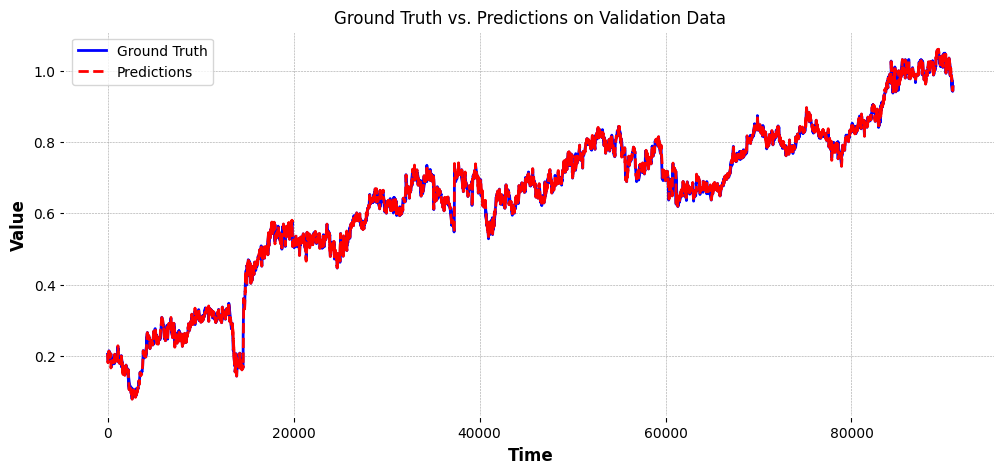

Average Test Loss: 0.0292


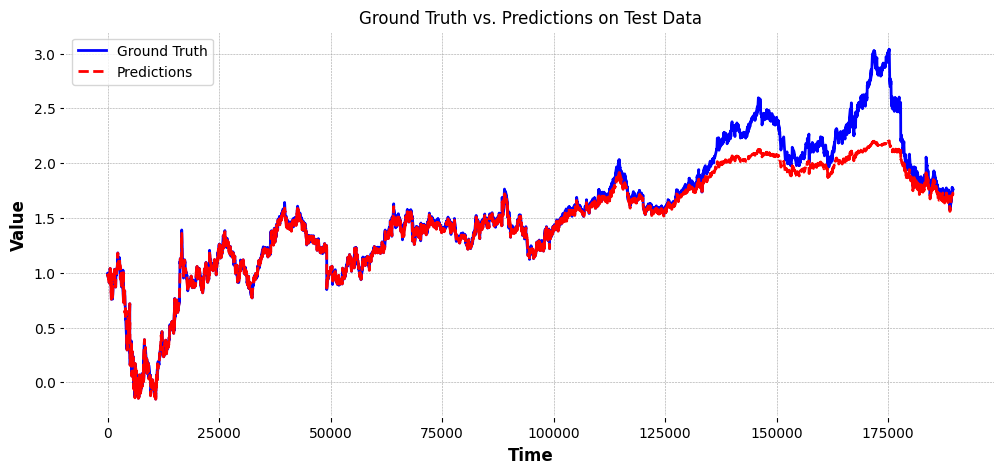

In [256]:
merged_train_time, merged_valid_time , merged_test_time ,valid_predictions,test_predictions,valid_true_values,test_true_values =  all_data(NDRE_1MIN,generate_sequences,Nmodel,num_epochs=10)

In [257]:
def finalStockData_updated_v2(df):
    new_df = df.copy()
    
    new_df.fillna(method='backfill', inplace=True)
    new_df.drop_duplicates(inplace=True)
    new_df.sort_values(by='Timestamp', inplace=True)
    
    # Add dayOfWeek column (Monday=1, Sunday=7)
    new_df['dayOfWeek'] = new_df['Timestamp'].dt.dayofweek + 1
    
    # Add monthOfYear column
    new_df['monthOfYear'] = new_df['Timestamp'].dt.month
    
    # Add year column
    new_df['year'] = new_df['Timestamp'].dt.year
    
    # Add hour column
    new_df['hour'] = new_df['Timestamp'].dt.hour
    
    # Drop 'High' and 'Low' columns
    #new_df.drop(columns=['High', 'Low'], inplace=True)
    
    return new_df




In [258]:
XDRE_1MIN.head()

,Timestamp,Open,High,Low,Close,Volume
0,2005-01-03 09:30:00,37.1719,37.1719,37.1563,37.1719,12800
1,2005-01-03 09:31:00,37.1757,37.1757,37.1757,37.1757,3600
2,2005-01-03 09:32:00,37.1757,37.2146,37.1757,37.2146,3800
3,2005-01-03 09:33:00,37.1835,37.1874,37.1796,37.1796,3200
4,2005-01-03 09:34:00,37.1757,37.1796,37.1408,37.1641,10000


In [259]:
LDRE_1MIN = finalStockData_updated_v2(XDRE_1MIN)
LDRE_1MIN.head()

,Timestamp,Open,High,Low,Close,Volume,dayOfWeek,monthOfYear,year,hour
0,2005-01-03 09:30:00,37.1719,37.1719,37.1563,37.1719,12800,1,1,2005,9
1,2005-01-03 09:31:00,37.1757,37.1757,37.1757,37.1757,3600,1,1,2005,9
2,2005-01-03 09:32:00,37.1757,37.2146,37.1757,37.2146,3800,1,1,2005,9
3,2005-01-03 09:33:00,37.1835,37.1874,37.1796,37.1796,3200,1,1,2005,9
4,2005-01-03 09:34:00,37.1757,37.1796,37.1408,37.1641,10000,1,1,2005,9


In [260]:
Lmodel = LSTMModel(input_dim = 9, hidden_dim =32, output_dim =1) 

0.0011094161979801865
4.988100285473842e-05
Epoch 1/10 => Train loss: 0.00110942, Validation loss: 0.00004988
7.340542219563724e-06
1.5455582821266946e-05
Epoch 2/10 => Train loss: 0.00000734, Validation loss: 0.00001546
5.755782962840849e-06
7.04017746829105e-06
Epoch 3/10 => Train loss: 0.00000576, Validation loss: 0.00000704
4.959848216367727e-06
5.454641826456645e-06
Epoch 4/10 => Train loss: 0.00000496, Validation loss: 0.00000545
4.550935864586944e-06
9.422003050971389e-06
Epoch 5/10 => Train loss: 0.00000455, Validation loss: 0.00000942
4.443480443217127e-06
1.2132903200819034e-05
Epoch 6/10 => Train loss: 0.00000444, Validation loss: 0.00001213
4.294644512884259e-06
1.3608091342677075e-05
Epoch 7/10 => Train loss: 0.00000429, Validation loss: 0.00001361
4.185047745413184e-06
5.017409050528415e-06
Epoch 8/10 => Train loss: 0.00000419, Validation loss: 0.00000502
4.04889936559344e-06
4.809465264300443e-06
Epoch 9/10 => Train loss: 0.00000405, Validation loss: 0.00000481
4.0274265

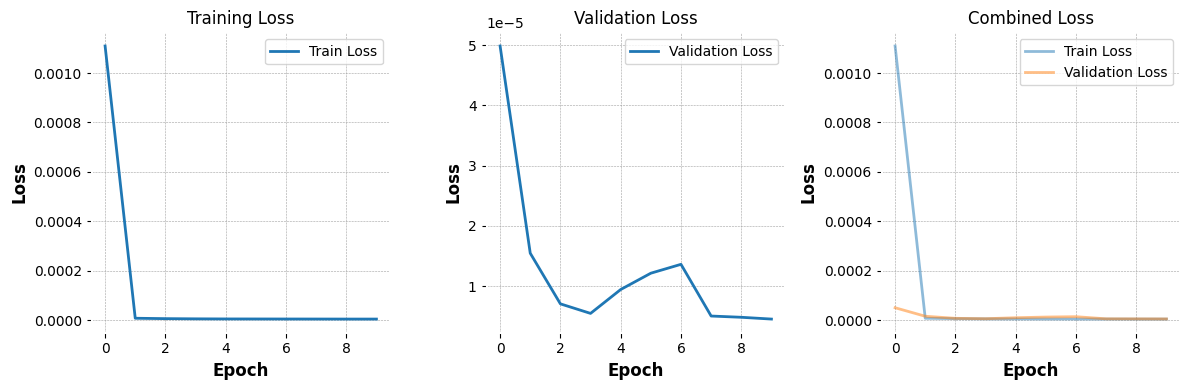

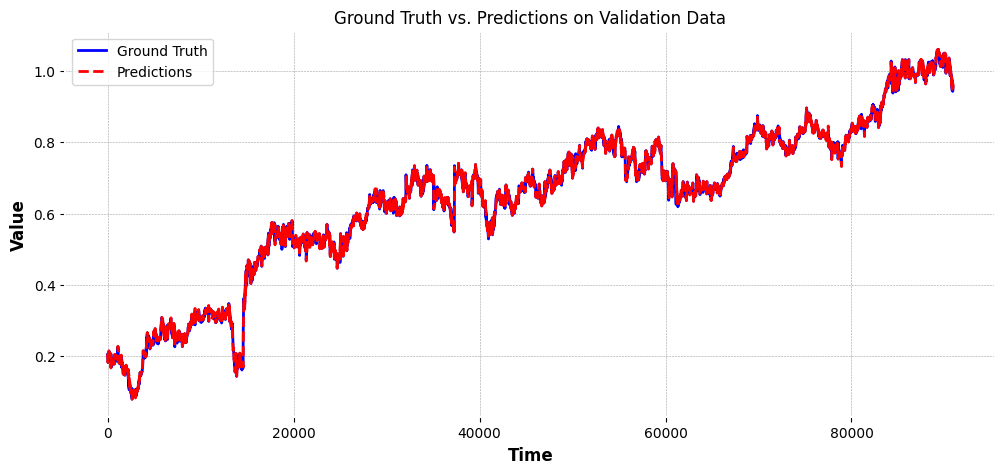

Average Test Loss: 0.0330


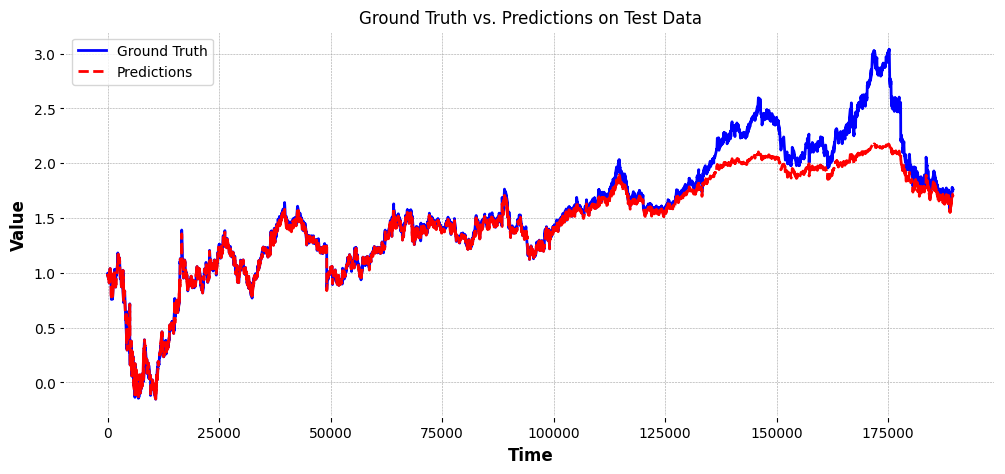

In [261]:
merged_train_time, merged_valid_time , merged_test_time ,valid_predictions,test_predictions,valid_true_values,test_true_values =  all_data(LDRE_1MIN,generate_sequences,Lmodel,num_epochs=10)

In [262]:
def finalStockData_updated_v4(df):
    new_df = df.copy()
    
    new_df.fillna(method='backfill', inplace=True)
    new_df.drop_duplicates(inplace=True)
    new_df.sort_values(by='Timestamp', inplace=True)
    
    # Add dayOfWeek column (Monday=1, Sunday=7)
    #new_df['dayOfWeek'] = new_df['Timestamp'].dt.dayofweek + 1
    
    # Add minute of the hour column
    new_df['minute'] = new_df['Timestamp'].dt.minute
    
    return new_df


In [263]:
JDRE_1MIN = finalStockData_updated_v4(XDRE_1MIN)

In [264]:
JDRE_1MIN.head()

,Timestamp,Open,High,Low,Close,Volume,minute
0,2005-01-03 09:30:00,37.1719,37.1719,37.1563,37.1719,12800,30
1,2005-01-03 09:31:00,37.1757,37.1757,37.1757,37.1757,3600,31
2,2005-01-03 09:32:00,37.1757,37.2146,37.1757,37.2146,3800,32
3,2005-01-03 09:33:00,37.1835,37.1874,37.1796,37.1796,3200,33
4,2005-01-03 09:34:00,37.1757,37.1796,37.1408,37.1641,10000,34


In [265]:
Jmodel = LSTMModel(input_dim=6 , hidden_dim=32 , output_dim=1)

0.0008169344786152326
5.945454783545484e-05
Epoch 1/10 => Train loss: 0.00081693, Validation loss: 0.00005945
6.790563859330882e-06
8.399907396287642e-06
Epoch 2/10 => Train loss: 0.00000679, Validation loss: 0.00000840
5.069615130861794e-06
1.1435040594088278e-05
Epoch 3/10 => Train loss: 0.00000507, Validation loss: 0.00001144
4.432320033382905e-06
7.672534673083986e-06
Epoch 4/10 => Train loss: 0.00000443, Validation loss: 0.00000767
4.186818203756937e-06
5.850025059794285e-06
Epoch 5/10 => Train loss: 0.00000419, Validation loss: 0.00000585
4.076440729472809e-06
5.626148728599647e-06
Epoch 6/10 => Train loss: 0.00000408, Validation loss: 0.00000563
3.999423658687252e-06
4.637852342300853e-06
Epoch 7/10 => Train loss: 0.00000400, Validation loss: 0.00000464
3.8538136756773595e-06
5.2821876750611146e-06
Epoch 8/10 => Train loss: 0.00000385, Validation loss: 0.00000528
3.871218038682732e-06
4.663005900767548e-06
Epoch 9/10 => Train loss: 0.00000387, Validation loss: 0.00000466
3.74898

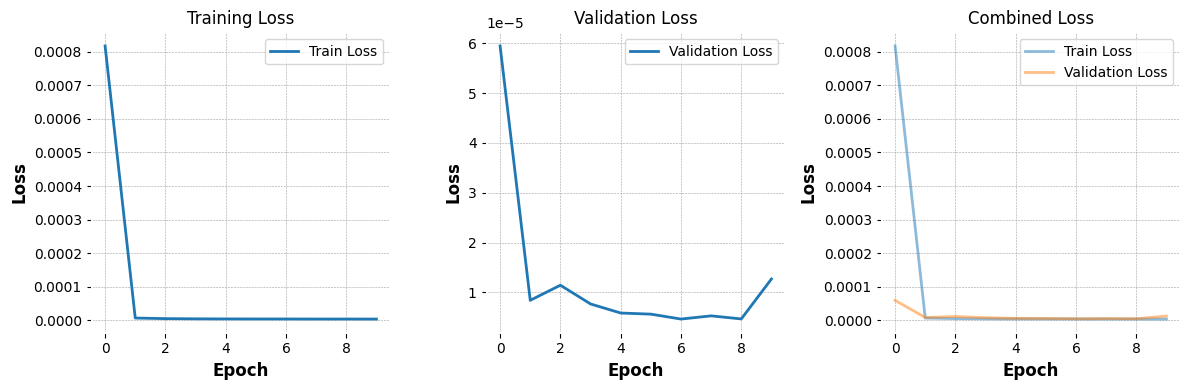

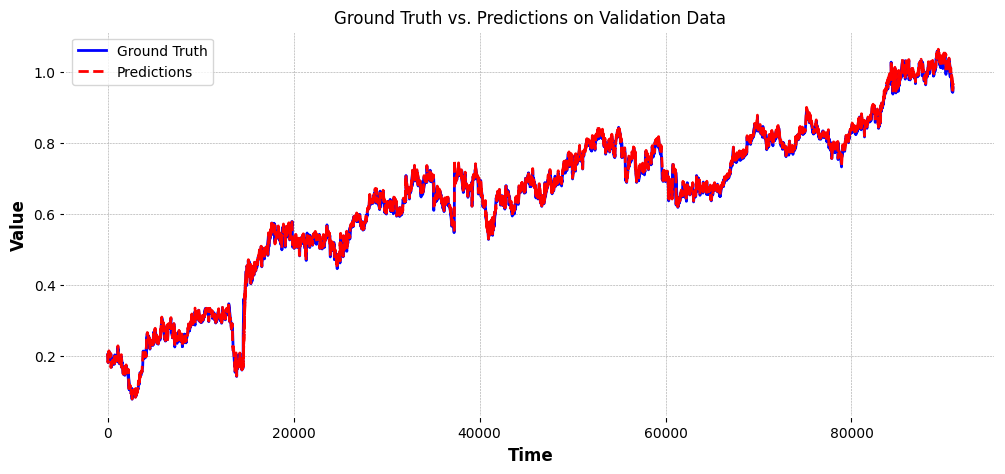

Average Test Loss: 0.0369


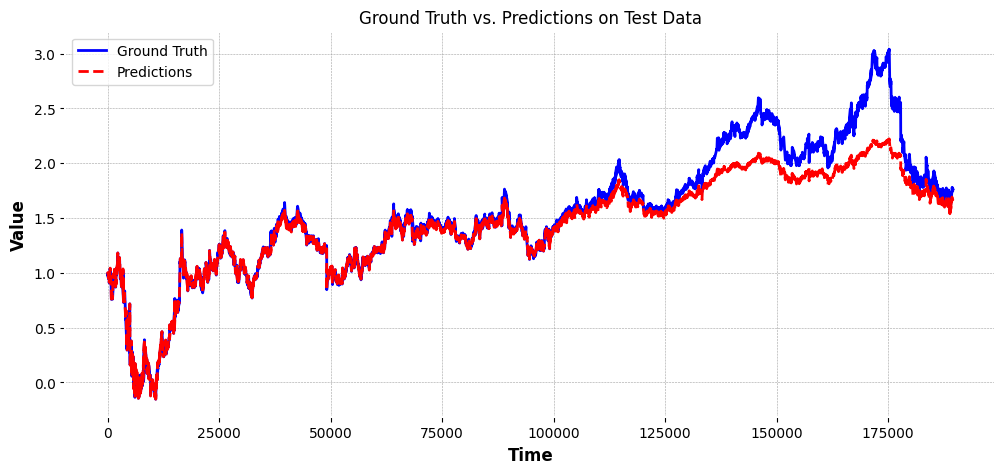

In [266]:
merged_train_time, merged_valid_time , merged_test_time ,valid_predictions,test_predictions,valid_true_values,test_true_values =  all_data(JDRE_1MIN,generate_sequences,Jmodel,num_epochs=10)